# 0.0. Imports

In [2]:
import pandas as pd
import numpy as np
import datetime
import inflection
import math

import seaborn as sns

from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
from IPython.display import Image

from scipy import stats
import sklearn


In [3]:
# setting seaborn figure sizes to occupy the whole screen
sns.set(rc={'figure.figsize':(20, 12)})

## 0.1. Helper functions

In [4]:
# cramer's v test on wikipedia in case of any refreshment, same name of variables as there
# cramer's v goes from 0, as no relation, to 1, maximum relation

def cramer_v( x, y ):
    contigency = pd.crosstab( x, y ).values
    n = contigency.sum()
    r, k = contigency.shape
    
    # take only the first result
    chi2 = stats.chi2_contingency( contigency )[0]
    chi2corr = max( 0, chi2 - ((k-1)*(r-1)/(n-1)) )
    
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt( (chi2corr/n) / (min( kcorr-1, rcorr-1)))    

## 0.2. Loading data

In [5]:
df_sales_raw = pd.read_csv("data/train.csv", low_memory=False)
df_store_raw = pd.read_csv("data/store.csv", low_memory=False)

# merge df's
df_raw = df_sales_raw.merge(df_store_raw, how="left", on="Store")

In [6]:
df_raw.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [7]:
df_raw.sample(5)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
102347,883,5,2015-05-01,0,0,0,1,a,0,a,a,3200.0,6.0,2005.0,0,NaN,NaN,NaN
529600,761,5,2014-03-14,7427,904,1,0,0,0,a,a,2390.0,9.0,2012.0,0,NaN,NaN,NaN
302889,153,2,2014-10-21,9408,751,1,1,0,0,a,a,16240.0,10.0,2000.0,1,18.0,2011.0,"Feb,May,Aug,Nov"
576814,30,4,2014-01-30,5287,858,1,0,0,0,a,a,40.0,2.0,2014.0,1,10.0,2014.0,"Mar,Jun,Sept,Dec"
678281,32,4,2013-10-31,5312,647,1,0,0,1,a,a,2910.0,NaN,NaN,1,45.0,2009.0,"Feb,May,Aug,Nov"


# 1.0. Data description

## 1.1. Rename Columns

In [8]:
df1 = df_raw.copy()

In [9]:
df1.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

In [10]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval']
snakecase = lambda x: inflection.underscore(x)

# map returns an iterable, so it must be transformed into a list
cols_new = list( map( snakecase, cols_old ) )

# rename
df1.columns = cols_new
df1.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval'],
      dtype='object')

## 1.2. Data Dimensions

In [11]:
# shape gives the number of rows and columns, [] are selection wich element
print( f"number of Rows {df1.shape[0]}" )
print( f"number of Cols {df1.shape[1]}" )

number of Rows 1017209
number of Cols 18


## 1.3. Data Types

In [12]:
df1.dtypes

store                             int64
day_of_week                       int64
date                             object
sales                             int64
customers                         int64
open                              int64
promo                             int64
state_holiday                    object
school_holiday                    int64
store_type                       object
assortment                       object
competition_distance            float64
competition_open_since_month    float64
competition_open_since_year     float64
promo2                            int64
promo2_since_week               float64
promo2_since_year               float64
promo_interval                   object
dtype: object

In [13]:
# change date col type from object to datetime64
df1["date"] = pd.to_datetime( df1["date"] )

df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4. Check NA

In [14]:
# .isna substitutes every value according to: value = na -> true, value != na -> false
# .sum in this case adds all the trues
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5. Fill NA

There are 3 different ways to handle NA's  
    1 - Delete every row that has one  
        Downside: it loses a lot of valuable data alongside  
    2 - Use Machine Learning algorithms to predict wich values wold be in NA places  
    3 - Understand the business

### 1.5.1 competition_distance

in this case I am using the third approach writen abbove:  
if there is an NA it is because there's no competition nearby  
therefore I will substitute every NA by a very large value, much greater than the max natural value

In [15]:

df1["competition_distance"].max()


75860.0

In [16]:
df1["competition_distance"] = df1["competition_distance"].apply( lambda x: 200000.0 if math.isnan(x) else x )

df1["competition_distance"].max()

200000.0

### 1.5.2 competition_open_since_month

In this particular case, with the engeneering future process in mind, I will take into account that this date is going to show how the stores were impacted by the opening of competidors.  
This NA might exist because there is no competition around the store or that there is competition but there is really no data regarding it's opening.  
I am going to substitute the NA by the month that the store itself opened, not the competidor. It is an artifitial substitution, but is a try. I am going to know if this works in the end, looking at the model created by the machine learnig algorithm. If it does not wields a good result, it is OK, I am going to try to make something different, that's just a beginning

In [17]:

df1["competition_open_since_month"] = df1.apply( lambda x: x["date"].month if math.isnan(x["competition_open_since_month"]) else x["competition_open_since_month"], axis=1 )


### 1.5.3 competition_open_since_year

Same principle as in the previous section

In [18]:

df1["competition_open_since_year"] = df1.apply( lambda x: x["date"].year if math.isnan(x["competition_open_since_year"]) else x["competition_open_since_year"], axis=1 )


### 1.5.4 promo2_since_week

Same as previous sections

In [19]:

df1["promo2_since_week"] = df1.apply( lambda x: x["date"].week if math.isnan(x["promo2_since_week"]) else x["promo2_since_week"], axis=1 )


### 1.5.5 promo2_since_year

Same as previous sections

In [20]:

df1["promo2_since_year"] = df1.apply( lambda x: x["date"].year if math.isnan(x["promo2_since_year"]) else x["promo2_since_year"], axis=1 )


### 1.5.6 promo_interval

Is a string containing months that have fixed promotions.  
To use this information better I am going to create a helper column, curr_month, and a new column is_promo2 that tells me if any promo2 is active in the current month. To remove the NA's in promo_interval I am simply going to substitute them for 0

In [21]:
# substitute all na's by 0 not returning anything (inplace=True) to make the subsequent comparison easier
df1["promo_interval"].fillna(0, inplace=True)

# create a map that will help trace each month to it's correspondent name abreviation
month_map = {1: "Jan", 2: "Feb", 3: "Mar", 4: "Apr", 5: "May", 6: "Jun", 7: "Jul", 8: "Aug", 9: "Sep", 8: "Oct", 9: "Nov", 10: "Dec", 11: "Nov", 12: "Dec"}

# make a column that shows the current mont name, not number
df1["curr_month"] = df1["date"].dt.month.map( month_map )

# helper function that will be given to apply
def in_promo_interval(x):
    if x["promo_interval"] == 0:
        return 0
    elif x["curr_month"] in x["promo_interval"].split(","):
        return 1
    else:
        return 0

# is_curr_in_promo2 will tell if there is a promo2 going on the current date, axis=1 to apply by row in all columns
df1["is_curr_in_promo2"] = df1[["promo_interval", "curr_month"]].apply(in_promo_interval, axis=1)


In [22]:
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
curr_month                      0
is_curr_in_promo2               0
dtype: int64

## 1.6. Change types

In [23]:
# every time you perform actions that change the data on the dataframe it is worthy to take another look at the
# types
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
curr_month                              object
is_curr_in_promo2                        int64
dtype: object

In [24]:
# change float64 to int
df1["competition_open_since_month"] = df1["competition_open_since_month"].astype( int )
df1["competition_open_since_year"] = df1["competition_open_since_year"].astype( int )
df1["promo2_since_week"] = df1["promo2_since_week"].astype( int )
df1["promo2_since_year"] = df1["promo2_since_year"].astype( int )

In [25]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
promo_interval                          object
curr_month                              object
is_curr_in_promo2                        int64
dtype: object

## 1.7. Descriptive Statistics

In [26]:
# divide numerical variables from categorical
num_attributes = df1.select_dtypes( include=["int64", "float64"] )
cat_attributes = df1.select_dtypes( exclude=["int64", "float64", "datetime64[ns]"] )

### 1.7.1. Numerical attributes

In [27]:
# Central Tendency - mean, median
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T

# Dispersiom - std, min, max, range, skew, kurtosis
# skew is how much skewed is a graph in relation to a normal distribution
# kurtosis is how concentrated or not are the values - high values => more concentrated => sharper peak
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T
d2 = pd.DataFrame( num_attributes.apply( min ) ).T
d3 = pd.DataFrame( num_attributes.apply( max ) ).T
d4 = pd.DataFrame( num_attributes.apply(lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame( num_attributes.apply(lambda x: x.skew() ) ).T
d6 = pd.DataFrame( num_attributes.apply(lambda x: x.kurtosis() ) ).T

m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
m.columns = ["attributes", "min", "max", "range", "mean", "median", "std", "skew", "kurtosis"]

m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


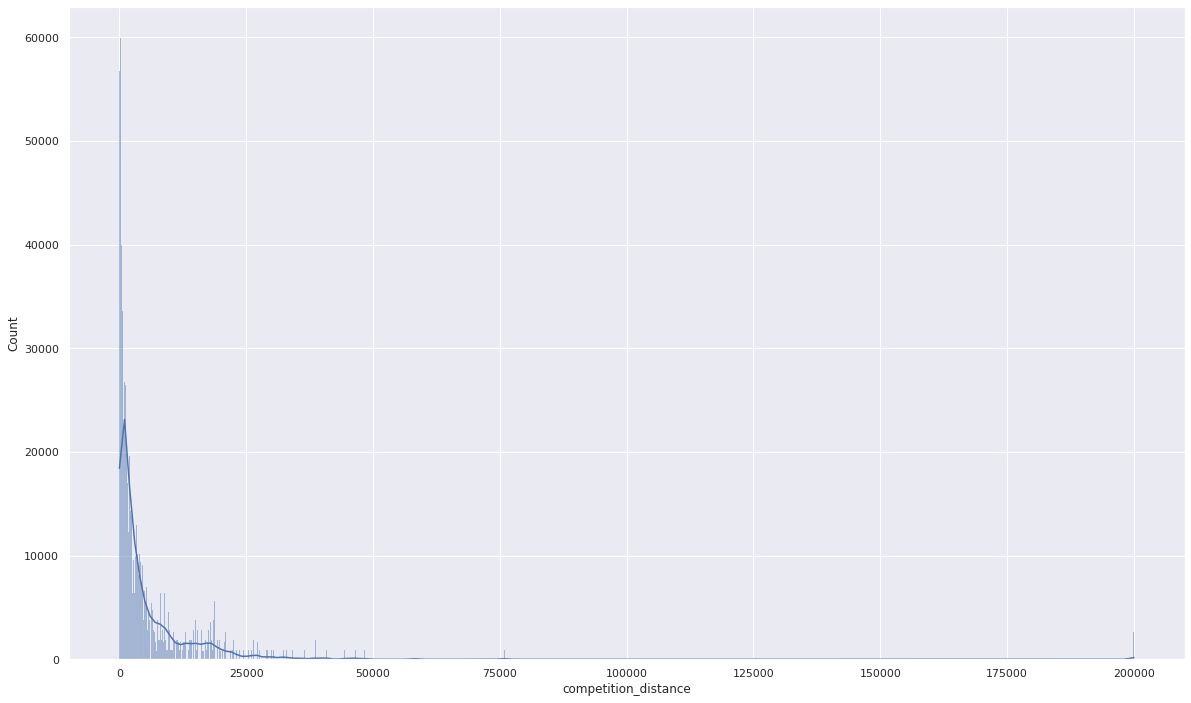

In [28]:
# notice that the huge kurtosis indicates that there is a big peak in the graph
# and that the great positive skew indicates that there is a deformation to the right

cd_plot = sns.histplot( df1["competition_distance"], kde=True )


### 1.7.2 Categorical attributes

In [29]:
# how many unique attributes
cat_attributes.apply(lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
curr_month        10
dtype: int64

<AxesSubplot:xlabel='assortment', ylabel='sales'>

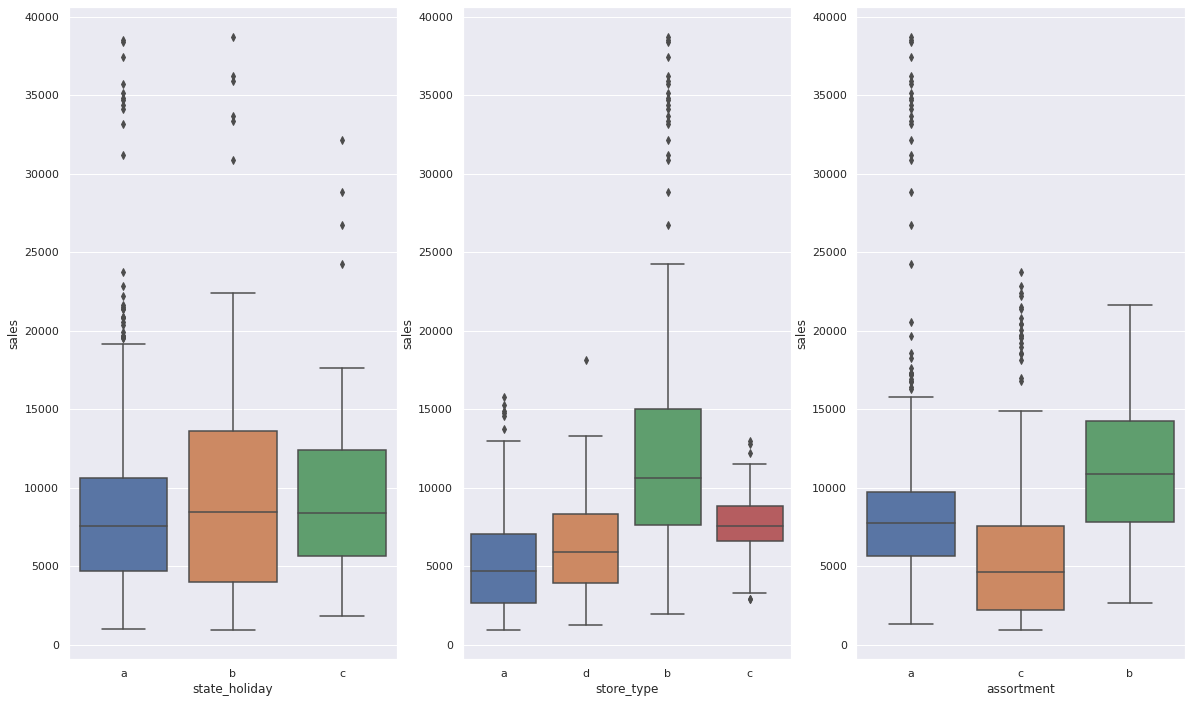

In [30]:
# filtering out the days that had not have holidays (0) and the sales that were 0, the data that happend in days
# that the stores were closed, possibly that closed during the holiday
aux1 = df1[(df1["state_holiday"] != "0") & (df1["sales"] > 0)]

# plt.subplot to separete the screen and 1, 3, 1 => 1 line, 3 columns, this one in the first position
plt.subplot(1, 3, 1)
sns.boxplot( x="state_holiday", y="sales", data=aux1)

plt.subplot(1, 3, 2)
sns.boxplot( x="store_type", y="sales", data=aux1)

plt.subplot(1, 3, 3)
sns.boxplot( x="assortment", y="sales", data=aux1)

# 2.0. Feature Engineering

## 2.1.1 Hypothesis mind map

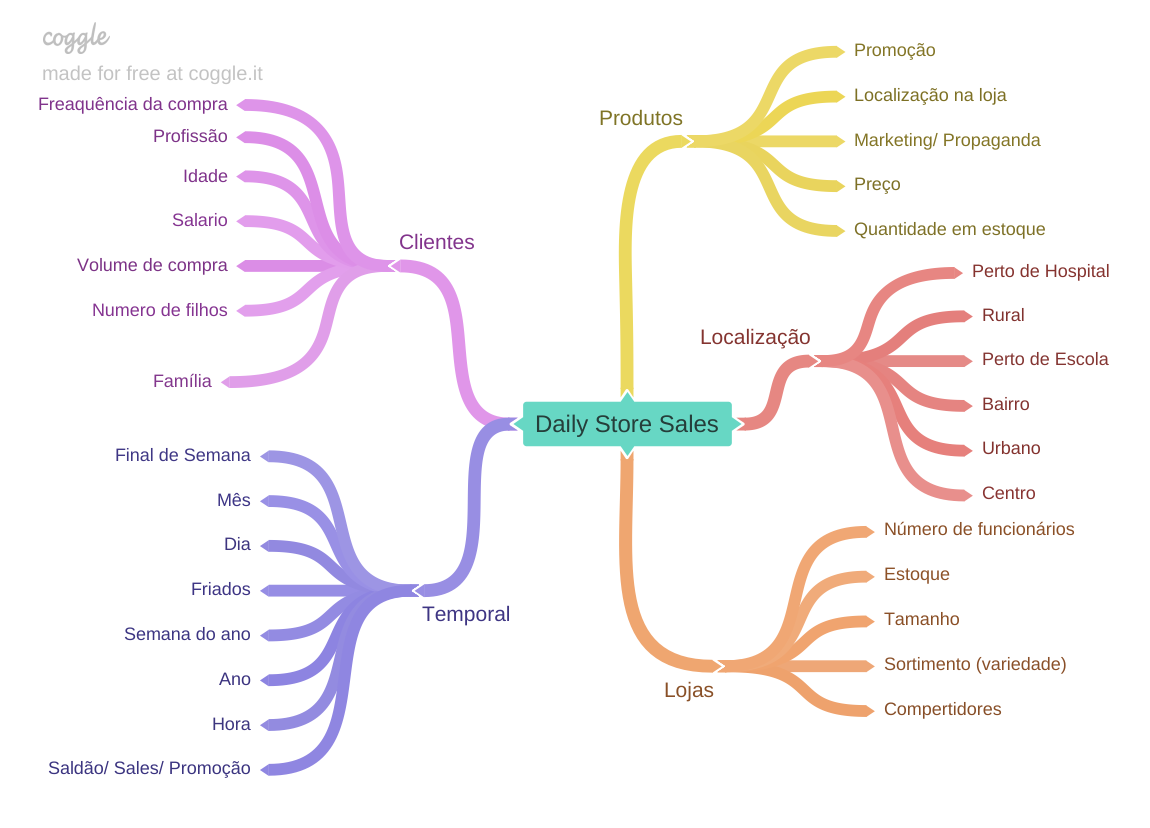

In [31]:
Image( "imgs/mindmap_store_sales.png" )

Having the mind map, the next step is formulating hypothesis  
Hypothesis are bets, that may or may not be validated through data

## 2.2. Hypothesis creation

These hypothesis are not implying in cause and effect, it is a correlation.

If you increase the size of a store, not necessarily you will increase sales, beacause there are many factors, including store size that are influencing in the sales level

And that is why we are trying to map all the attributes thare are influencing here

### 2.2.1 Hypothesis related to stores

**1.** Stores with larger staff should sell more

**2.** Stores with larger stock should sell more (stock is not only the part that is kept in storage, away from the public, but what is exposed as well)

**3.** Larger stores should sell more

**4.** Stores with larger assorment should sell more (greater variety in products, a client can come to buy something and ending up buying something else as well)

**5.** Stores with close competitors should sell less

**6.** Stores with longer-term competitors should sell more

### 2.2.2 Hypothesis related to product

**1.** Stores investing more in marketing should sell more

**2.** Stores displaying more products in the showcase should sell more

**3.** Stores with lower prices for the same product should sell more

**4.** Stores with more aggresive promotions should sell more (cheaper product)

**5.** Stores with longer sales (promotions) periods should sell more

**6.** Stores with longer sales consecutive days should sell more

**7.** Stores with more consecutive sales periods should sell more

### 2.2.3 Hypothesis related to time (seasonality)

**1.** Stores that open during the christmas holiday should sell more

**2.** Stores should sell more along the years 

**3.** Stores should sell more during the last half of the year

**4.** Stores should sell more after the tenth day of the month 

**5.** Stores should sell less on weekends

**6.** Stores should sell less on school holidays

## 2.4. Final hypothesis list - priorities

The priority is given by the availability of the data.

If you already have the data in the table, test the hypothesis.

If the machine learning algorithm is not perfoming well or the hypothesis is very relevant you can comeback in the next cicle and look for the missing data for these hypothesis

### 2.4.1 Store hypothesis 

**1.** Stores with larger assorment should sell more (greater variety in products, a client can come to buy something and ending up buying something else as well)

**2.** Stores with close competitors should sell less

**3.** Stores with longer-term competitors should sell more

### 2.4.1 Product hypothesis 

**1.** Stores with longer sales (promotions) periods should sell more

**2.** Stores with longer sales consecutive days should sell more

**3.** Stores with more consecutive sales periods should sell more

### 2.4.1 Time hypothesis 

**1.** Stores that open during the christmas holiday should sell more

**2.** Stores should sell more along the years 

**3.** Stores should sell more during the last half of the year

**4.** Stores should sell more after the tenth day of the month 

**5.** Stores should sell less on weekends

**6.** Stores should sell less on school holidays

## 2.5. Feature Engineering

Creating variables/columns for future processing, foreseeing future variables needs

In [32]:
df2 = df1.copy()

In [33]:
df2.sample(5).T

,529119,876797,315150,258322,74812
store,280,78,281,523,108
day_of_week,5,1,3,1,1
date,2014-03-14 00:00:00,2013-05-06 00:00:00,2014-10-08 00:00:00,2014-12-08 00:00:00,2015-05-25 00:00:00
sales,6089,3372,5596,14928,0
customers,482,486,491,1735,0
open,1,1,1,1,0
promo,0,0,1,0,0
state_holiday,0,0,0,0,a
school_holiday,0,0,0,0,0
store_type,d,a,d,c,d


In [34]:
# YEAR
df2["year"] = df2["date"].dt.year

# MONTH
df2["month"] = df2["date"].dt.month

# DAY
df2["day"] = df2["date"].dt.day

# WEEK OF YEAR
df2["week_of_year"] = df2["date"].dt.isocalendar().week

# YEAR WEEK - just a date format (2015-30)
df2["year_week"] = df2["date"].dt.strftime("%Y-%W")


# COMPETITION SINCE

# forming a datetime from columns ...since_year and ...since_month
df2["competition_since"] = df2.apply( lambda x: datetime.datetime( year=x["competition_open_since_year"], month=x["competition_open_since_month"], day=1 ), axis=1 )

# the result of the subtraction of df2["date"] and df2["competition_since"] is a number of days, so we divide
# by 30 to get the number of months
# the problem is that now we have a datetime obj that has a number of weeks in it's days property
# so we use apply to extract days and transform the resulting str in integer 
df2["competition_time_in_months"] = ( ( df2["date"] - df2["competition_since"] ) / 30 ).apply( lambda x: x.days ).astype(int)


# PROMO2 SINCE
# first join the str values of promo2_since_year and promo2_since_week
df2["promo2_since"] = df2["promo2_since_year"].astype(str) + "-" + df2["promo2_since_week"].astype(str)

# then loop through all values a transformation to datetime obj from a str using strptime
# the x is the str, the "-1" is a concatenation of strs, transforming "2012-31" to "2012-31-1", symbolizing the
# assumption that the week day in wich the promo2 began was sunday, and the "%Y-%W-%w" is
# the format that the given str is
# the subtraction of datetime.timedelta( days=7 ) means that we are taking off a week from the number
# aproximately transforming the value from ISO to a count that has the first week of the year in other day
# probably to maintain the same date format throughout the project
df2["promo2_since"] = df2["promo2_since"].apply( lambda x: datetime.datetime.strptime( x + "-1", "%Y-%W-%w" ) - datetime.timedelta( days=7 ) )

# then subtract and divide by seven to get the number of weeks, as in COMPETITION SINCE
df2["promo2_time_in_weeks"] = ( ( df2["date"] - df2["promo2_since"] ) / 7 ).apply( lambda x: x.days ).astype(int)


# ASSORTMENT
# a = basic, b = extra, c = extended
df2["assortment"] = df2["assortment"].apply(lambda x: "basic" if x == "a" else "extra" if x == "b" else "extended")

# STATE HOLIDAY
# a = public holiday, b = Easter holiday, c = Christmas, 0 = None
df2["state_holiday"] = df2["state_holiday"].apply(lambda x: "public_holiday" if x == "a" else "easter_holiday" if x == "b" else "christmas" if x == "c" else "regular_day")

In [35]:
df2.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


# 3.0. Variable filtering

Variable filtering is a proccess that takes into consideration a business analysis.

You will take out from the analysis data that although relevant is not available in the business side.
And also take into account the higher priority of the demand. Perhaps the boss wants attention in a given store type only. You can filter out the other types.

i.e. An analysis that discovered that higher discounts yelds higher sales. However the business team does not know discounts before the product is lauch, therefore it is a information that has no impact in any planing of product launching.

Filtering helps preventing this scenario. If you know that discounts can not be use, you can choose another variable for the analysis.

In [36]:
df3 = df2.copy()

## 3.1. Row filtering

Rows where **"open"** == 0. These are days in wich no sales were made, so there is no valuable information here.

Rows where **"sales"** > 0. Same reason as above.

In [37]:
df3 = df3[(df3["open"] != 0) & (df3["sales"] > 0)]

## 3.2. Column filtering

Col **"customers"**: There is no prediction of the amount of custumers that will visit the store in the future, just the amount in the date of the recording. No comparison available, business restriction

Droping "open" column as well, because once the 0 were filtered out there remains only 1 in every cell no relevant info remains there

Cols promo_interval and curr_month used just to derive is_curr_in_promo2 col 

In [38]:
# droping "open" column as well, because once the 0 were filtered out there remains only 1 in every cell
# no relevant info remains there

cols_drop = ["customers", "open", "promo_interval", "curr_month"]
df3 = df3.drop( cols_drop, axis=1 )

# 4.0. Exploratory Data Analysis

In [39]:
df4 = df3.copy()

## 4.1. Univariate Analysis

### 4.1.1 Response variable

<AxesSubplot:xlabel='sales', ylabel='Count'>

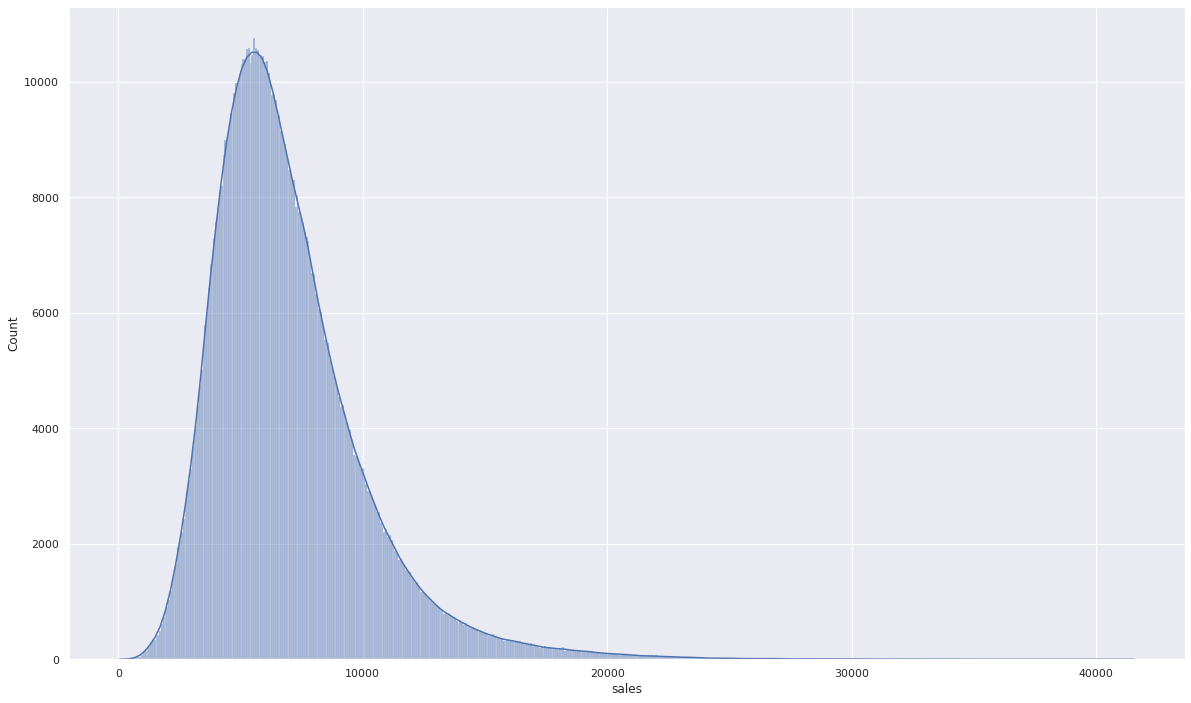

In [40]:
sns.histplot(df4["sales"], kde=True)

<AxesSubplot:xlabel='sales', ylabel='Count'>

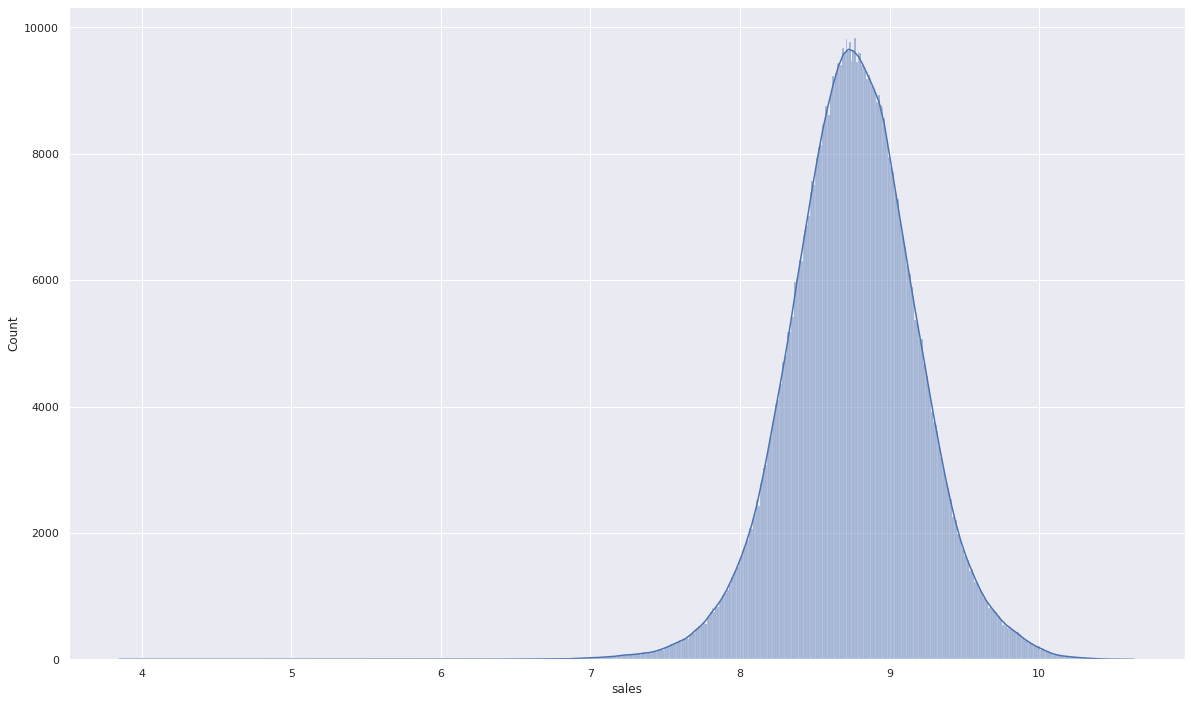

In [41]:
# if we wanted to normalize more:
sns.histplot( np.log1p( df4["sales"] ), kde=True )
# there is no need in this case

### 4.1.2 Numerical variable

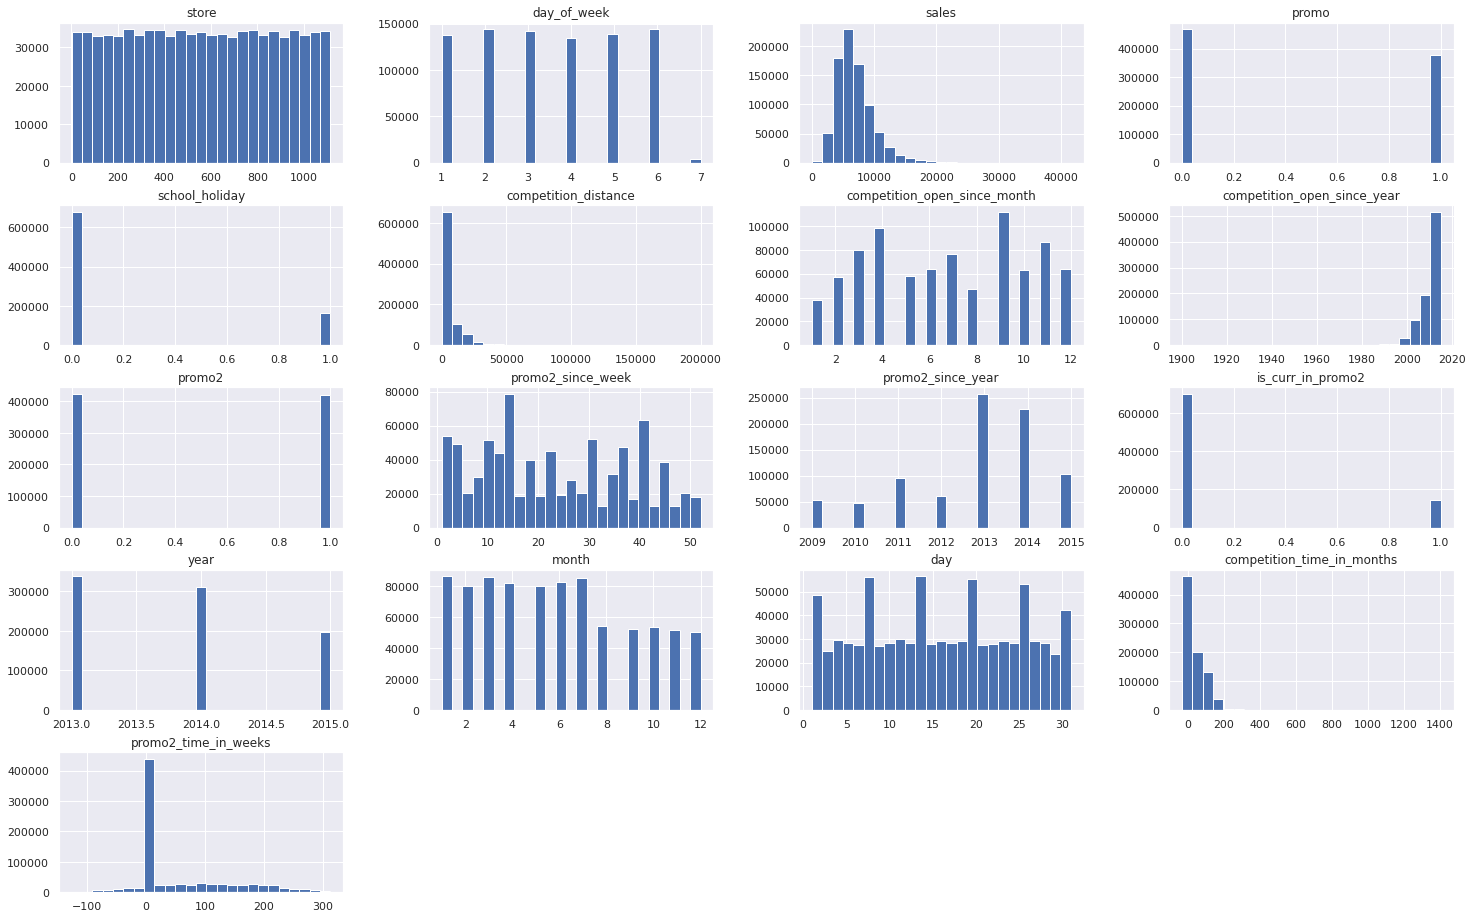

In [42]:
num_attributes = df4.select_dtypes( include=["int64", "float64"] )
num_attributes.hist( bins=25, figsize=(25,16) );

### 4.1.3 Categorical variable

In [43]:
cat_attributes = df4.select_dtypes( exclude=["int64", "float64", "datetime64[ns]"] )

In [44]:
# to know what are the possible options for each column
sh_unique = df4["state_holiday"].drop_duplicates().reset_index()["state_holiday"]
st_unique = df4["store_type"].drop_duplicates().reset_index()["store_type"]
as_unique = df4["assortment"].drop_duplicates().reset_index()["assortment"]
pd.concat([sh_unique, st_unique, as_unique], axis=1)

,state_holiday,store_type,assortment
0,regular_day,c,basic
1,public_holiday,a,extended
2,easter_holiday,d,extra
3,christmas,b,NaN


<AxesSubplot:title={'center':'Out of Proportion Densities of Sales by Holiday'}, xlabel='sales', ylabel='Density'>

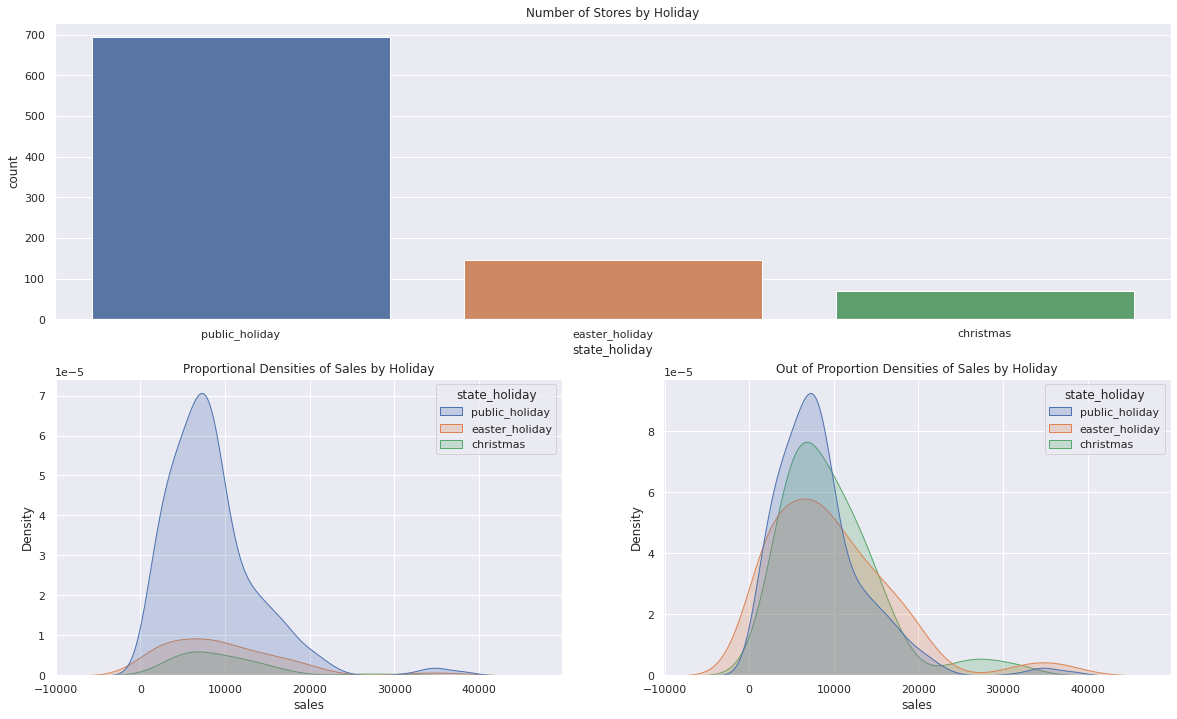

In [45]:
# STATE HOLIDAY

# since most colected days are regular days, it's bar gets out of proportion, not allowing the visualization
# of the other variables, better filter it out for visualization
# fig, axs = plt.subplots(nrows=2, ncols=2)
plt.subplot(2, 1, 1).set_title("Number of Stores by Holiday")
not_a_regular_day = df4[df4["state_holiday"] != "regular_day"]
sns.countplot( x=not_a_regular_day["state_holiday"] )

# ====== Important ======
# in the kdeplot the option common_norm=False produces a plot that is out of proportion
# it makes easter and christmas larger than they really are because they are not comparing with each other
# when common_norm=True, the default setting, density of values is distributed between the graphs,
# so that their shared area sum (integral) is 1
# when false, their individual area integral is equal to 1
plt.subplot(2, 2, 3).set_title("Proportional Densities of Sales by Holiday")
sns.kdeplot( data=not_a_regular_day, x="sales", hue="state_holiday", shade=True )

# ploted this out of proportion graph for the visual comparison of skew and kurtosis
# and to take into account that naturaly if there were more stores opened in public holidays
# there were a higher profit for those days
# the out of proportion gives an idea of the perfect world in wich there were the same amount of stores opened 
# in each holiday
plt.subplot(2, 2, 4).set_title("Out of Proportion Densities of Sales by Holiday")
sns.kdeplot( data=not_a_regular_day, x="sales", hue="state_holiday", shade=True, common_norm=False )

<AxesSubplot:title={'center':'Out of Proportion Densities of Sales by Store Type'}, xlabel='sales', ylabel='Density'>

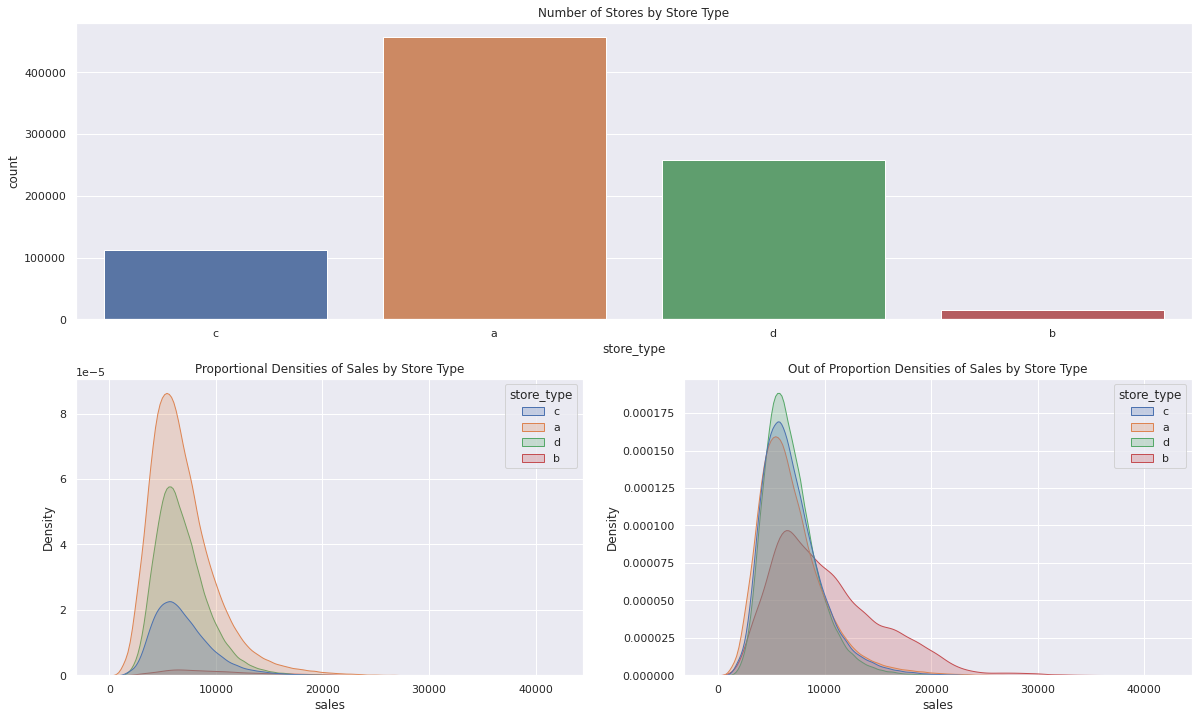

In [46]:
# STORE TYPE
plt.subplot(2, 1, 1).set_title("Number of Stores by Store Type")
sns.countplot(x=df4["store_type"])

plt.subplot(2, 2, 3).set_title("Proportional Densities of Sales by Store Type")
sns.kdeplot( data=df4, x="sales", hue="store_type", shade=True)

plt.subplot(2, 2, 4).set_title("Out of Proportion Densities of Sales by Store Type")
sns.kdeplot( data=df4, x="sales", hue="store_type", shade=True, common_norm=False)

<AxesSubplot:title={'center':'Out of Proportion Densities of Sales by Store Assortment'}, xlabel='sales', ylabel='Density'>

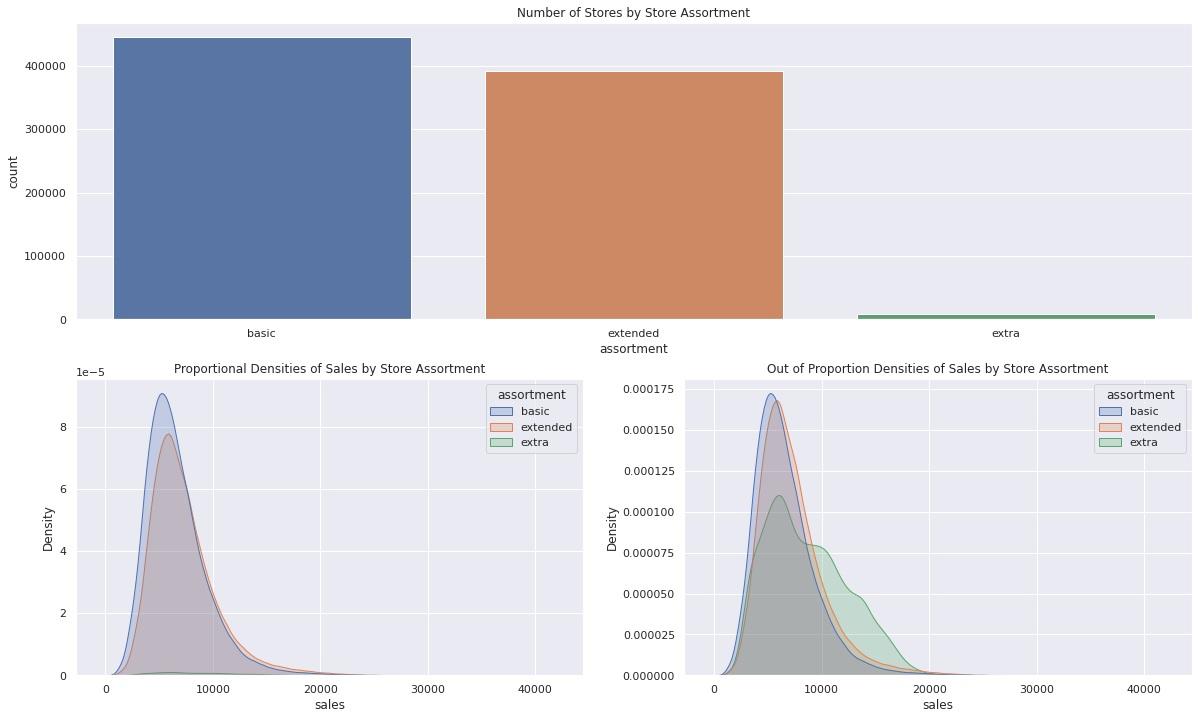

In [47]:
# ASSORTMENT
plt.subplot(2, 1, 1).set_title("Number of Stores by Store Assortment")
sns.countplot(x=df4["assortment"])

plt.subplot(2, 2, 3).set_title("Proportional Densities of Sales by Store Assortment")
sns.kdeplot( data=df4, x="sales", hue="assortment", shade=True)

plt.subplot(2, 2, 4).set_title("Out of Proportion Densities of Sales by Store Assortment")
sns.kdeplot( data=df4, x="sales", hue="assortment", shade=True, common_norm=False)

## 4.2. Bivariate Analysis

Here are the analysis made with the hypothesis formulated in the Feature Engineering section.

There are two sub analysis groups, in both subsections the same hypothesis were scrutinized. 
The biggest technical difference between both is that in the first subsection the analysis were made using the mean sales values, whence in the second subsection the analysis were made using the sum of the sales values.

Personally, I believe there are **more useful insights in 4.2.1**, but the other subsection is useful for generating insights for the whole company.

**In 4.2.1** there are the analysis made using the **mean**. Which means that the results are evaluations made about the average store.  
**In 4.2.2** there are the analysis made using the **sum**. Which means that the results are evaluations made about the whole business sales.

i.e. For the hypothesis that the stores are selling more over the years. The average store sells more over the years, sales increasing over years. But the added value for the whole business will tell otherwise, that stores are selling less. That is happening because there was more data collected, more stores measured in the first years, and the last recorded year, 2015, was not over. Therefore, with more stores measured in the first years naturally the added value is higher, not that the stores were individually selling more in the beginning, but that there were more stores sending data.

### 4.2.1 Analysis made for the average store

#### 4.2.1.1 Hypothesis: Stores with larger assortment should sell more

**TRUE** - Individually, stores with higher assortment sell more, and sell more over time, but in the added value of all stores of each type the higher assortment sold way less 

In [48]:
aux1 = df4[["assortment", "sales"]].groupby("assortment").mean().reset_index()
aux1

,assortment,sales
0,basic,6621.523057
1,extended,7300.843547
2,extra,8642.503594


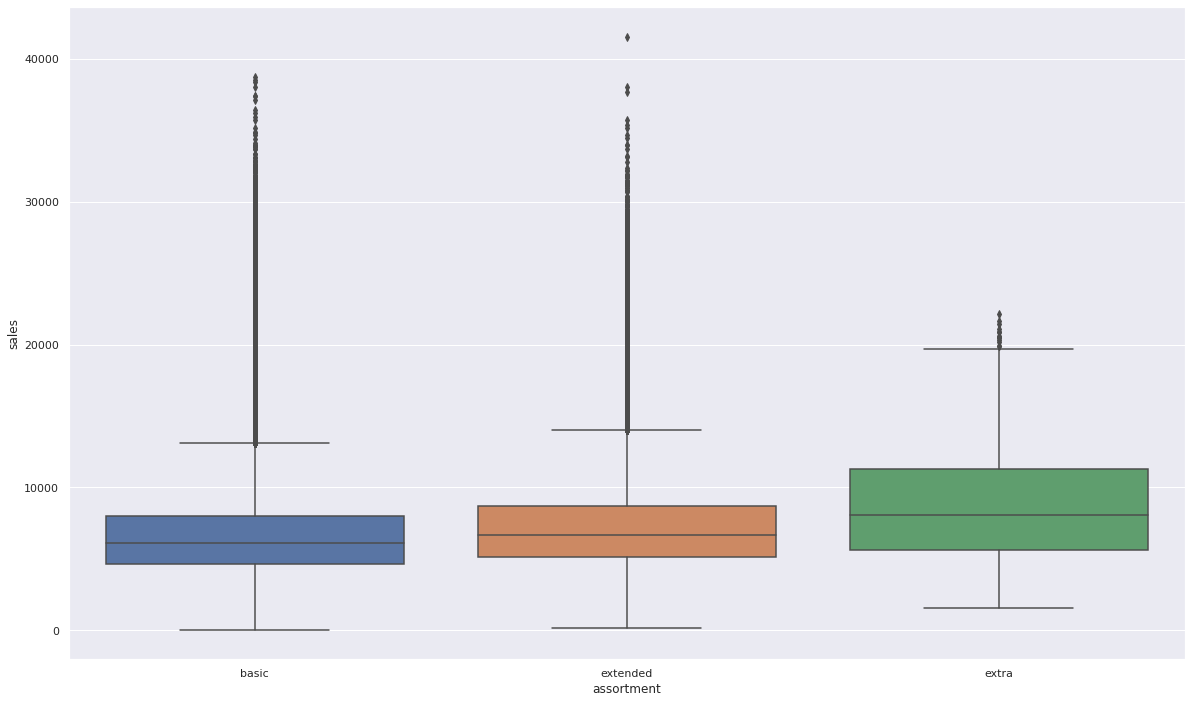

In [49]:
sns.boxplot( x="assortment", y="sales", data=df4);

In an individual analysis level, a single extra type store sells more than either extended or basic type stores

If the profit of the average extra store type is higher in comparison with the other types, one question might be raised: were the profits of the "extras" changing over time? In other words, was there any interesting variation in the profit over the registered time?

In [50]:
aux3 = df4[["year_week", "assortment", "sales"]].groupby(["year_week", "assortment"]).mean().reset_index()
aux3.head()

,year_week,assortment,sales
0,2013-00,basic,5642.277194
1,2013-00,extended,6094.001471
2,2013-00,extra,5282.431373
3,2013-01,basic,7307.459961
4,2013-01,extended,7553.623270


In [51]:
# reorganizing the graph
pivot_aux3 = aux3.pivot(index="year_week", columns="assortment", values="sales")
pivot_aux3.head()

assortment,basic,extended,extra
year_week,,,
2013-00,5642.277194,6094.001471,5282.431373
2013-01,7307.459961,7553.623270,6254.982143
2013-02,5049.444788,5283.317073,6286.783333
2013-03,6853.631919,6983.376397,6423.206349
2013-04,5611.939028,5944.287541,6483.232143


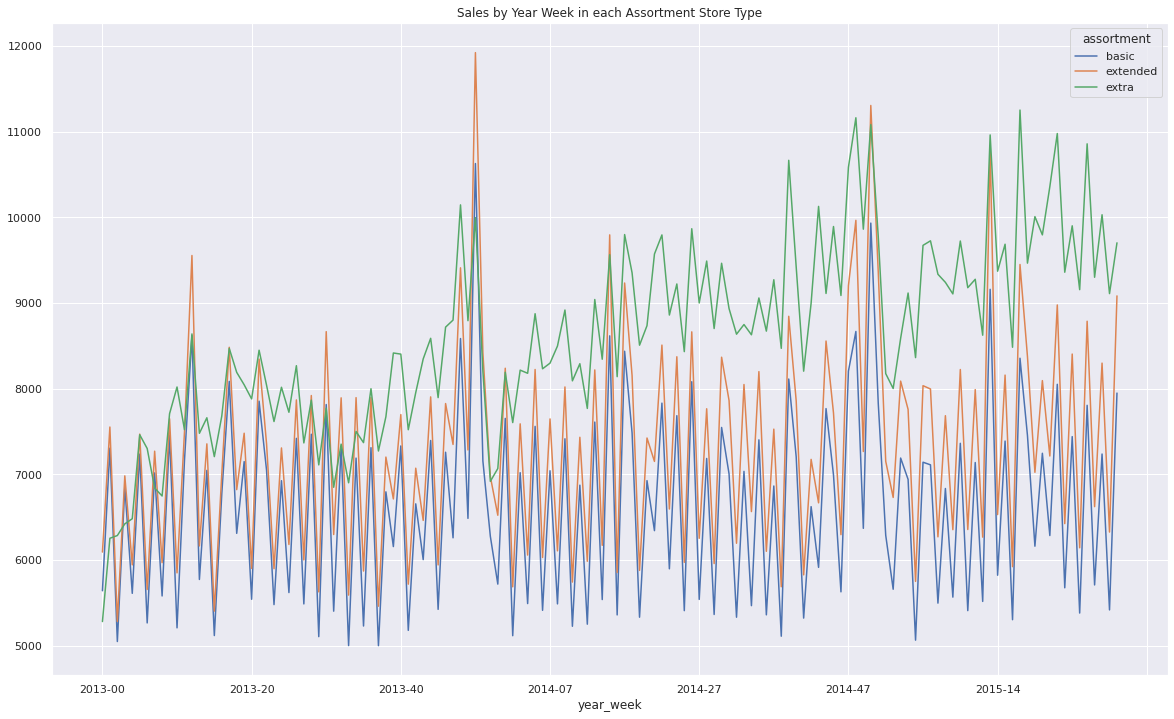

In [52]:
pivot_aux3.plot(title="Sales by Year Week in each Assortment Store Type");

#### 4.2.1.2 Hypothesis: Stores with close competitors should sell less
**FALSE** - Stores with close competitors do not sell less. They generally sell the same, the competitor's distance not influencing, but have a slightly decrease in sales when the competitor is farther. Even so, it seems that this slightly decrease might be inside the confidence interval

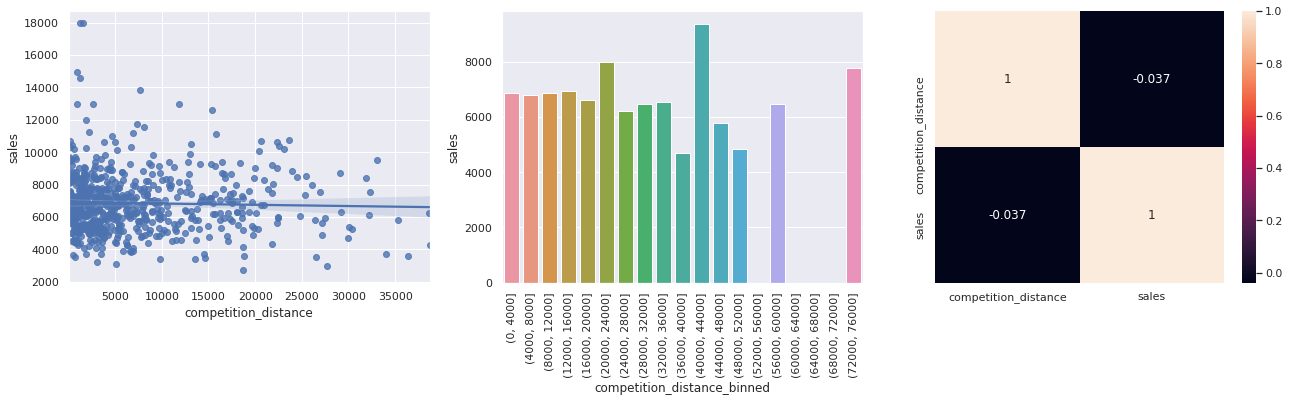

In [53]:
# grouping and taking the mean instead of the sum
aux1 = df4[["competition_distance", "sales"]].groupby("competition_distance").mean().reset_index()

plt.figure(figsize=(22, 5))

# ==== REGRESSION ====
# regression instead of a pure scatterplot to make it easyer to notice that the trend line is almost horizontal
# meaning no correlation
plt.subplot(131)
sns.regplot(data=aux1[aux1["competition_distance"] < 40000], x="competition_distance", y="sales")

# ==== BARPLOT ====
plt.subplot(132)
bins = list( range( 0, 80000, 4000 ) )

# pd.cut is made exactaly for assigning values to bins, numerical values to categorical
aux1["competition_distance_binned"] = pd.cut( x=aux1["competition_distance"], bins=bins )
aux2 = aux1[["competition_distance_binned", "sales"]].groupby("competition_distance_binned").mean().reset_index()
sns.barplot( data=aux2, x="competition_distance_binned", y="sales")
plt.xticks(rotation=90)

# ==== CORRELATION HEATMAP ====
plt.subplot(133)
sns.heatmap(aux1.corr(method="pearson"), annot=True);


A good approach is instead o evaluate the sum of all stores at a given distance, take their mean, in order to not inflate the result by the huge amount of stores with near competitors

We can see above that the sales do not vary, or very very little, with the distance.

#### 4.2.1.3. Stores with longer-term competitors should sell more
**TRUE** - However, this result only exists when we balance the sales by the amount of stores in the data. If we do not take this into consideration the relation between variables is inverse (the hypothesis would be **false**)

By the analysis bellow the relation between long-term competitors and sales is negative, the longer the competition, smaller the sales

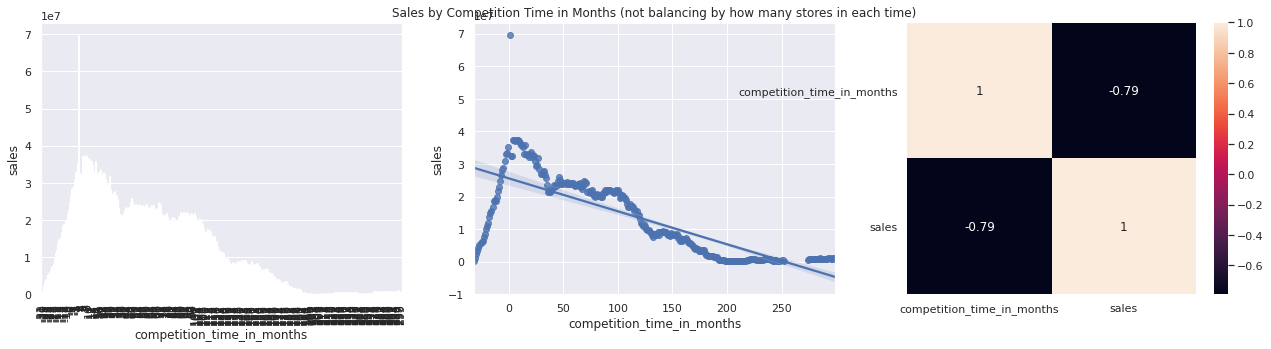

In [54]:
aux1 = df4[["competition_time_in_months", "sales"]].groupby("competition_time_in_months").sum().reset_index()
aux1 = aux1[(aux1["competition_time_in_months"] != 0) & (aux1["competition_time_in_months"] < 300)]

plt.figure(figsize=(22, 5))

plt.subplot(131)
sns.barplot(data=aux1, x="competition_time_in_months", y="sales")
plt.xticks(rotation=90);

plt.subplot(132)
sns.regplot(data=aux1, x="competition_time_in_months", y="sales");
plt.title("Sales by Competition Time in Months (not balancing by how many stores in each time)");

plt.subplot(133)
sns.heatmap(aux1.corr(method="pearson"), annot=True);

Yet, one must take into account that this value have a strong influence comming from the ammount of stores that were measured that were concentrated around the 0. This naturaly make a peak in sales in this months, meaning that since we have more stores around the 0, when we sum up them, we have a higher cumulative sale.

Bellow is shown the higher concentration of measures around 0

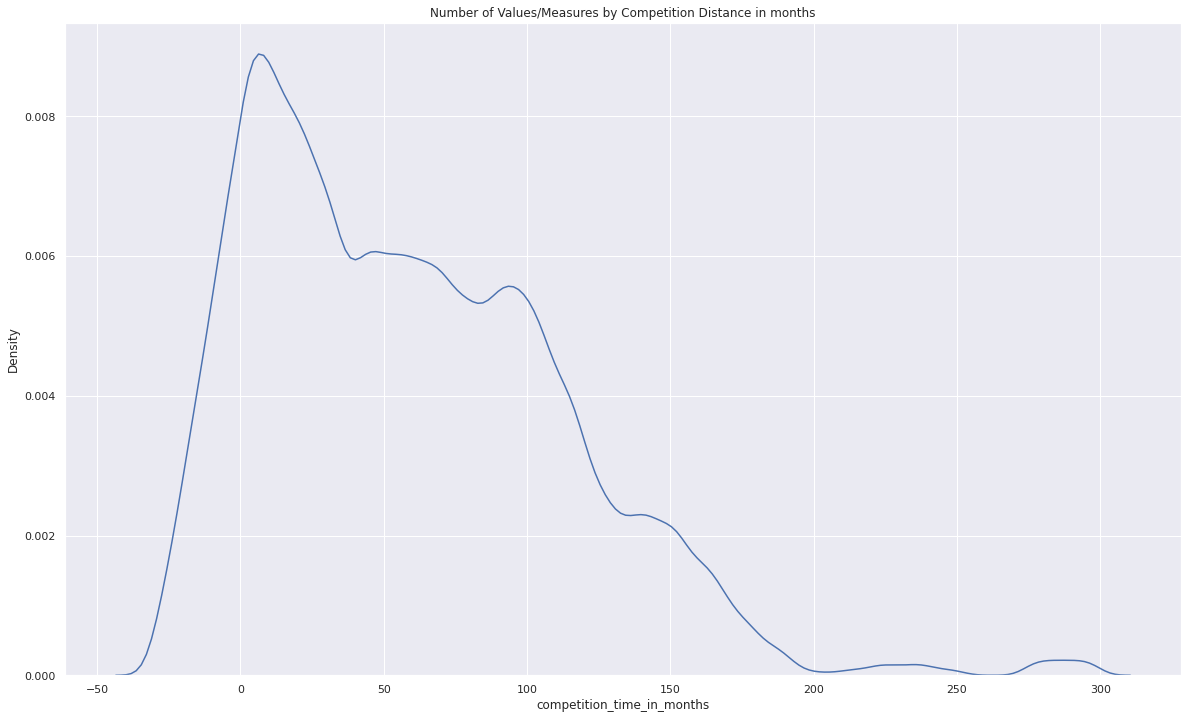

In [55]:
aux1 = df4.loc[(df4["competition_time_in_months"] != 0) & (df4["competition_time_in_months"] < 300), ["competition_time_in_months", "sales"]]
sns.kdeplot(data=aux1, x="competition_time_in_months");
plt.title("Number of Values/Measures by Competition Distance in months");

Bellow is the exact actions made above (except the bar chart that was too difficult to visualize), just that now we are taking the mean of values in any given month, effectively removing the additional effect of the greater amount of data around the 0 months

Therefore discovering a positive high correlation between the variables, meaning that yes, the sales go up the longer the competition time span

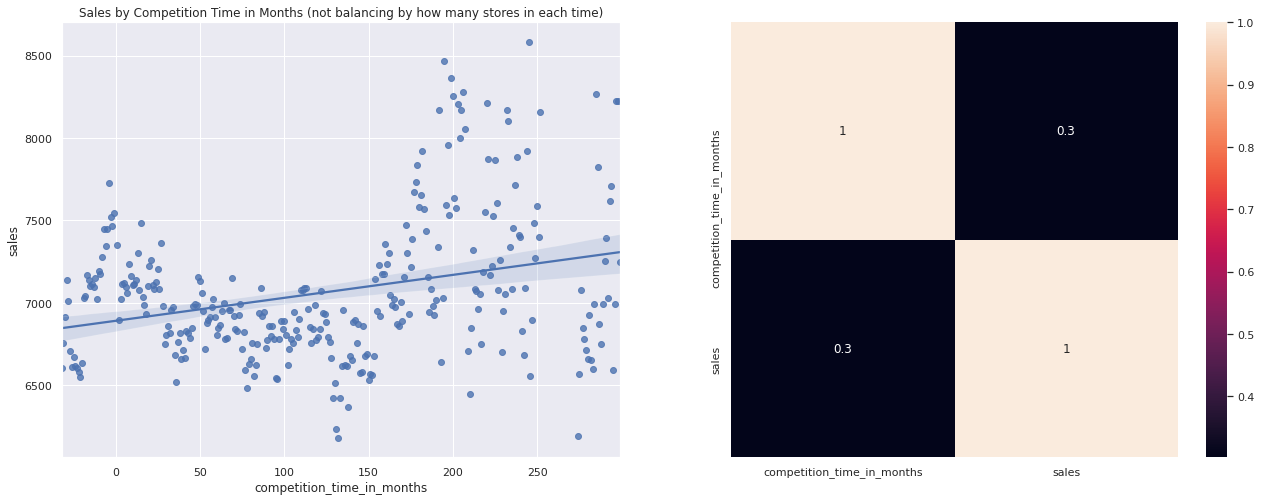

In [56]:
aux1 = df4[["competition_time_in_months", "sales"]].groupby("competition_time_in_months").mean().reset_index()
aux1 = aux1[(aux1["competition_time_in_months"] != 0) & (aux1["competition_time_in_months"] < 300)]

plt.figure(figsize=(22, 8))

plt.subplot(121)
sns.regplot(data=aux1, x="competition_time_in_months", y="sales");
plt.title("Sales by Competition Time in Months (not balancing by how many stores in each time)");

plt.subplot(122)
sns.heatmap(aux1.corr(method="pearson"), annot=True);

#### 4.2.1.4  Stores with longer sales (promotions) periods should sell more - Is sales growing inside Promo2?
**TRUE** - Balancing the data to consider the higher amount of data available for promo2 between 0 and 200 weeks, we can see that the sales are going up

**However** We can not say that the growth of sales is directly related to the longer Promo2, that it is the cause. There are many factors influencing the growth of the stores, this might be even a natural growth related to the natural growth of a store after it opens. It is only a correlation! 

<AxesSubplot:>

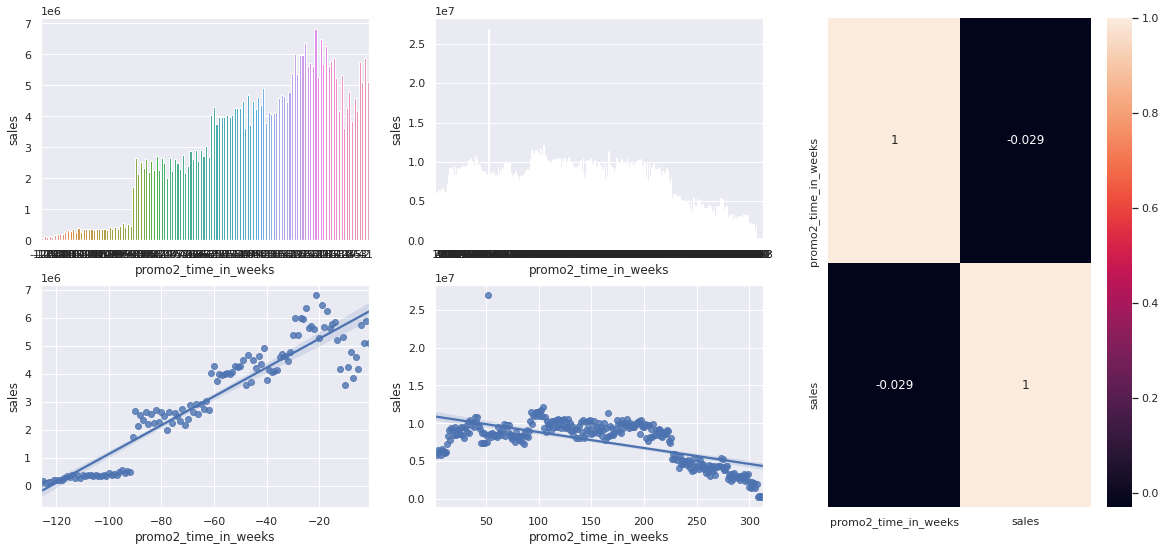

In [57]:
aux1 = df4[["promo2_time_in_weeks", "sales"]].groupby("promo2_time_in_weeks").sum().reset_index()

plt.figure(figsize=(20, 9))
grid = gridspec.GridSpec(2, 3)

plt.subplot(grid[0, 0])
aux2 = aux1[aux1["promo2_time_in_weeks"] < 0]
sns.barplot(data=aux2, x="promo2_time_in_weeks", y="sales");

plt.subplot(grid[0, 1])
aux3 = aux1[aux1["promo2_time_in_weeks"] > 0]
sns.barplot(data=aux3, x="promo2_time_in_weeks", y="sales");

plt.subplot(grid[1, 0])
sns.regplot(data=aux2, x="promo2_time_in_weeks", y="sales");

plt.subplot(grid[1, 1])
sns.regplot(data=aux3, x="promo2_time_in_weeks", y="sales");

# the correlation is made using the whole dataset (aux1 here), not the parts
plt.subplot(grid[:, 2])
sns.heatmap(aux1.corr(method="pearson"), annot=True)

The plots above were analysing the data without considering the higher amount of data registered for stores that were in promo2 between 0 and 200 weeks, as shown in the graph bellow. Because of that, when adding all the values, the result is inflated, more values are added for these days, resulting in more cumulative sales.

<AxesSubplot:ylabel='Count'>

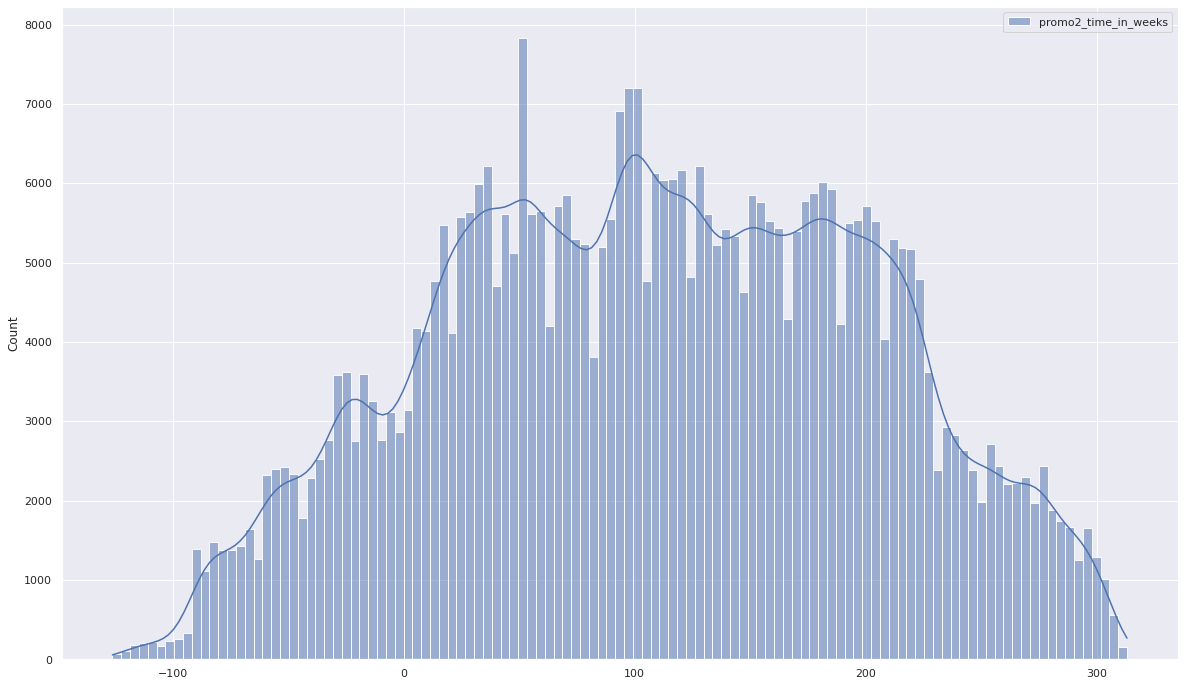

In [58]:
aux1 = df4.loc[df4["promo2_time_in_weeks"] != 0, ["promo2_time_in_weeks"]]
sns.histplot(data=aux1, kde=True)

Taking that into consideration we may take the mean, not the sum, in order to balance the data. This way the higher amount of registered measures of stores between 0 and 200 will make less of a impact in the result

<AxesSubplot:>

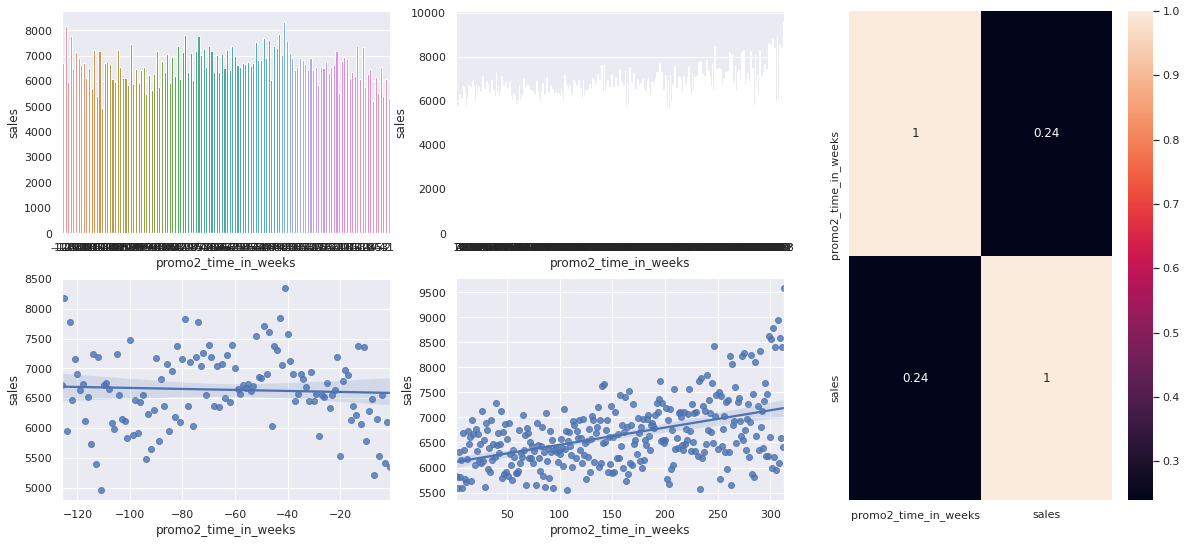

In [59]:
aux1 = df4[["promo2_time_in_weeks", "sales"]].groupby("promo2_time_in_weeks").mean().reset_index()

plt.figure(figsize=(20, 9))
grid = gridspec.GridSpec(2, 3)

plt.subplot(grid[0, 0])
aux2 = aux1[aux1["promo2_time_in_weeks"] < 0]
sns.barplot(data=aux2, x="promo2_time_in_weeks", y="sales");

plt.subplot(grid[0, 1])
aux3 = aux1[aux1["promo2_time_in_weeks"] > 0]
sns.barplot(data=aux3, x="promo2_time_in_weeks", y="sales");

plt.subplot(grid[1, 0])
sns.regplot(data=aux2, x="promo2_time_in_weeks", y="sales");

plt.subplot(grid[1, 1])
sns.regplot(data=aux3, x="promo2_time_in_weeks", y="sales");

# the correlation is made using the whole dataset (aux1 here), not the parts
plt.subplot(grid[:, 2])
sns.heatmap(aux1.corr(method="pearson"), annot=True)

#### <s>4.2.1.5. Stores with longer sales consecutive days should sell more</s>

I do not believe that there is data to test the hypothesis

#### 4.2.1.6 Stores with more consecutive promotions should sell more
**FALSE** - Stores with "promo2" sell less than without, the higher sellers are the ones with only "promo"

One cause of this behavior might be that a lot of the stores that are now in a "promo2" were stores that were already underperforming in sales and entered promo2 to help raise their sales 

In [60]:
df4[["promo", "promo2", "sales"]].groupby(["promo", "promo2"]).mean().reset_index().sort_values(by="sales")

,promo,promo2,sales
1,0,1,5529.566684
0,0,0,6328.187633
3,1,1,7836.672987
2,1,0,8618.452062


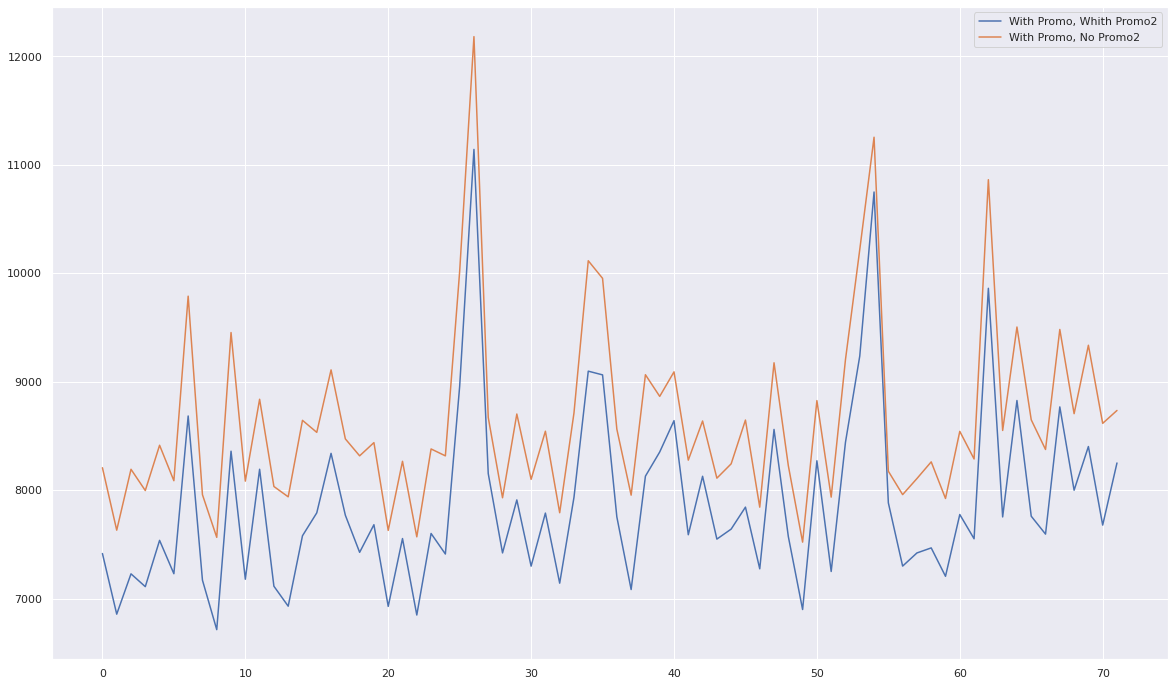

In [61]:
aux1 = df4.loc[(df4["promo"] == 1) & (df4["promo2"] == 1), ["year_week", "sales"]].groupby("year_week").mean().reset_index()
ax = aux1.plot()

aux2 = df4.loc[(df4["promo"] == 1) & (df4["promo2"] == 0), ["year_week", "sales"]].groupby("year_week").mean().reset_index()
aux2.plot(ax=ax)

ax.legend(labels=["With Promo, Whith Promo2", "With Promo, No Promo2"])

#### 4.2.1.7. Stores that open during the christmas holiday should sell more
**FALSE** - There is not enough data to say this. In 2013 it was false, but it was true in 2014, 2015 is not closed in the data

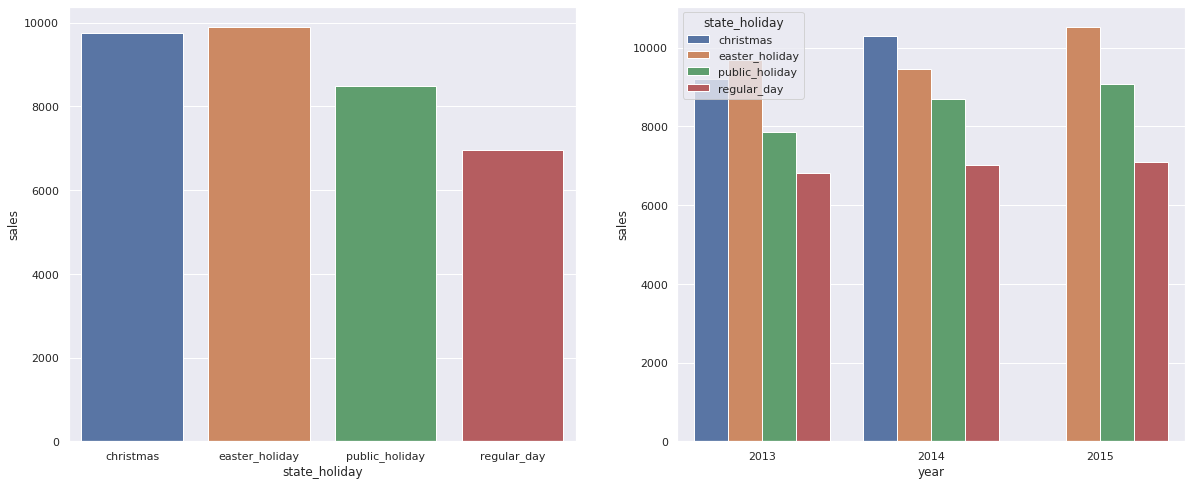

In [62]:
plt.figure(figsize=(20, 8))

plt.subplot(121)
aux = df4
aux1 = aux[["state_holiday", "sales"]].groupby("state_holiday").mean().reset_index()
sns.barplot(data=aux1, y="sales", x="state_holiday");

plt.subplot(122)
aux2 = aux[["year", "state_holiday", "sales"]].groupby(["year", "state_holiday"]).mean().reset_index()
sns.barplot(data=aux2, y="sales", x="year", hue="state_holiday");

#### 4.2.1.8. Stores should sell more over the years
**TRUE** - stores are selling more through the years, the mean store sale value is growing

<AxesSubplot:>

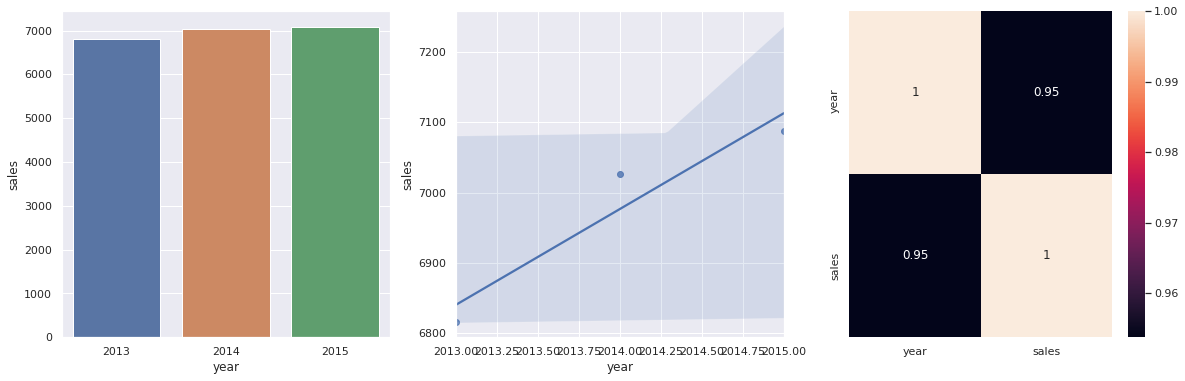

In [63]:
plt.figure(figsize=(20, 6))

plt.subplot(131)
aux1 = df4[["year", "sales"]].groupby("year").mean().reset_index()
sns.barplot(data=aux1, x="year", y="sales")

plt.subplot(132)
sns.regplot(data=aux1, x="year", y="sales")

plt.subplot(133)
sns.heatmap(aux1.corr(method="pearson"), annot=True)

#### 4.2.1.9. Stores should sell more during the last half of the year
**TRUE** - They sell more on the last half

<AxesSubplot:>

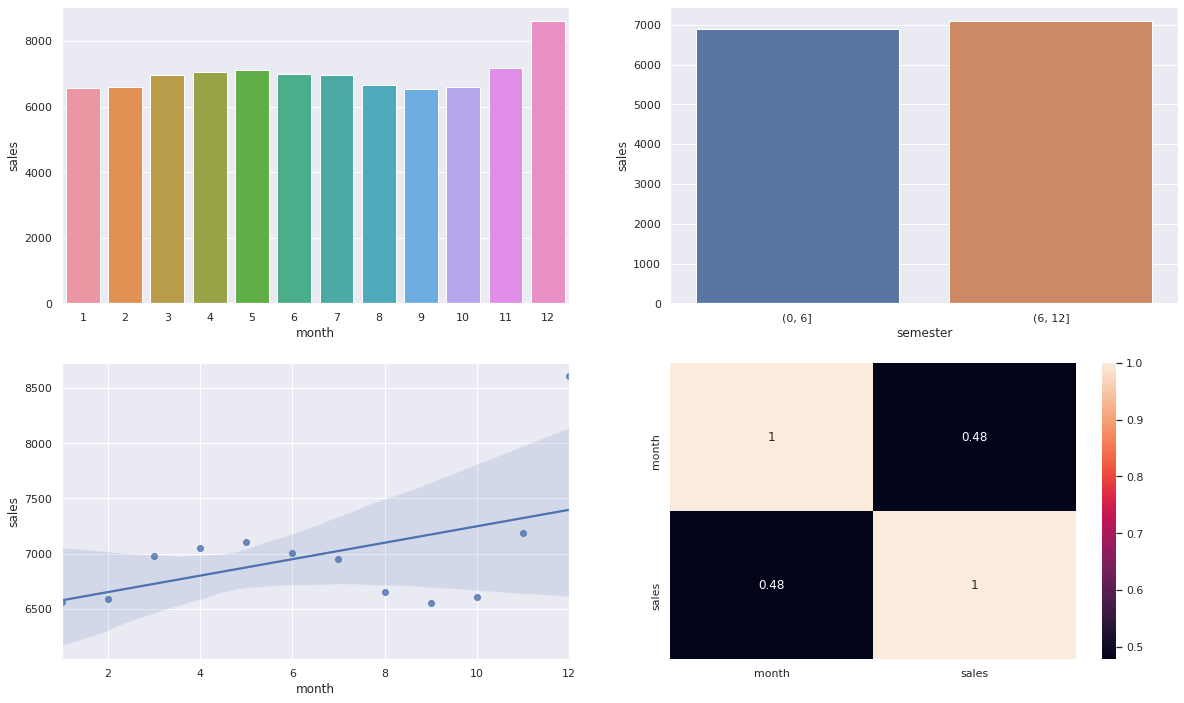

In [64]:
plt.figure(figsize=(20, 12))

plt.subplot(221)
aux1 = df4[["month", "sales"]].groupby("month").mean().reset_index()
sns.barplot(data=aux1, x="month", y="sales")

plt.subplot(222)
aux2 = aux1.copy()
aux2["semester"] = pd.cut(x=aux1["month"], bins=list(range(0, 13, 6)))
aux2 = aux2[["semester", "sales"]].groupby("semester").mean().reset_index()
sns.barplot(data=aux2, x="semester", y="sales");

plt.subplot(223)
sns.regplot(data=aux1, x="month", y="sales")

plt.subplot(224)
sns.heatmap(aux1.corr(method="pearson"), annot=True)

#### 4.2.1.10. Stores should sell more after the tenth day of the month
**FALSE** - Stores sell more in the begining of the month

<AxesSubplot:xlabel='before_after', ylabel='sales'>

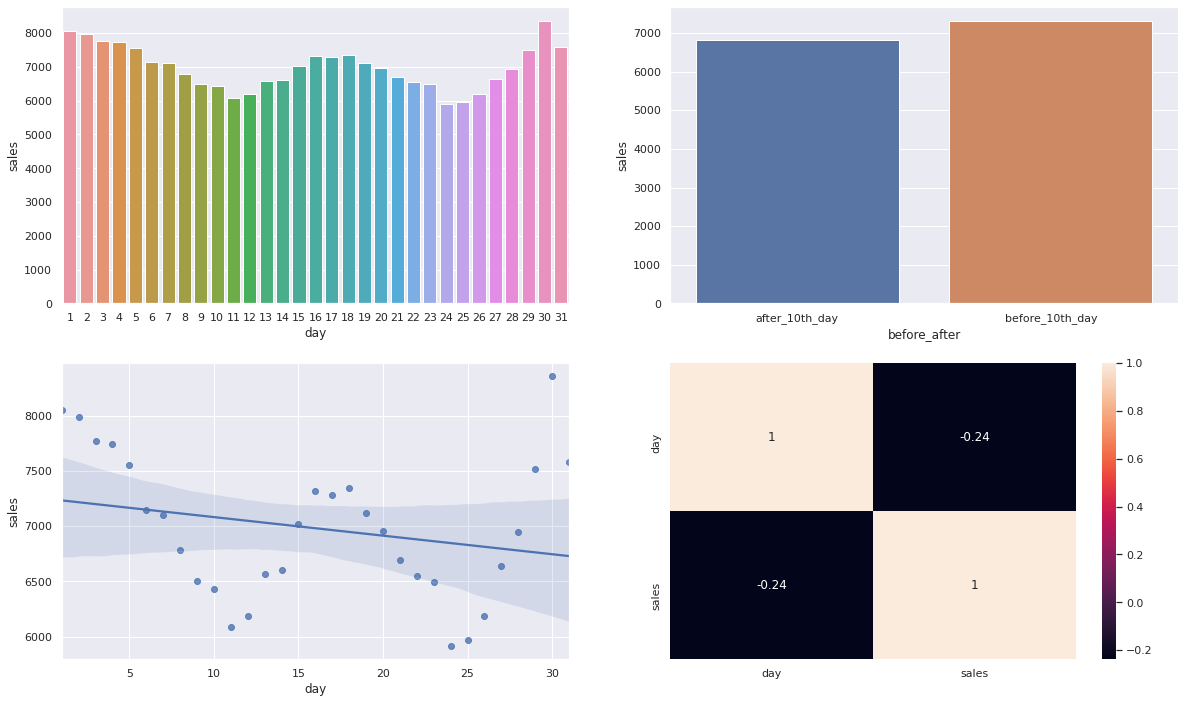

In [65]:
plt.figure(figsize=(20, 12))

plt.subplot(221)
aux1 = df4[["day", "sales"]].groupby("day").mean().reset_index()
sns.barplot(data=aux1, x="day", y="sales")

plt.subplot(223)
sns.regplot(data=aux1, x="day", y="sales")

plt.subplot(224)
sns.heatmap(aux1.corr(method="pearson"), annot=True)

plt.subplot(222)
aux1["before_after"] = aux1["day"].apply(lambda x: "before_10th_day" if x <= 10 else "after_10th_day")
aux2 = aux1.groupby("before_after").mean().reset_index()
sns.barplot(data=aux2, x="before_after", y="sales")

#### 4.2.1.11. Stores should sell less on weekends
**TRUE** - the stores sales slightly decreases along the week

<AxesSubplot:>

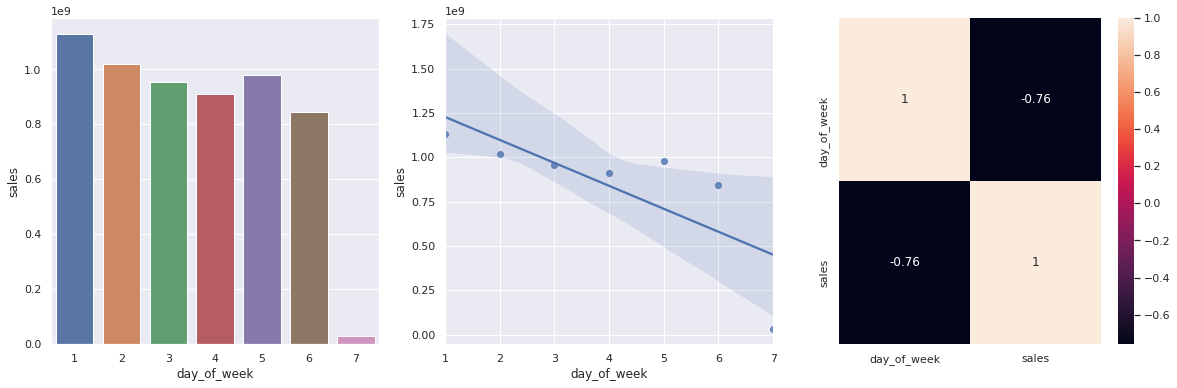

In [66]:
plt.figure(figsize=(20, 6))

plt.subplot(131)
aux1 = df4[["day_of_week", "sales"]].groupby("day_of_week").sum().reset_index()
sns.barplot(data=aux1, x="day_of_week", y="sales")

plt.subplot(132)
sns.regplot(data=aux1, x="day_of_week", y="sales")

plt.subplot(133)
sns.heatmap(aux1.corr(method="pearson"), annot=True)

Sales on sunday are very low. This is caused by the greater number of stores closed on Sundays:

<AxesSubplot:xlabel='day_of_week', ylabel='Count'>

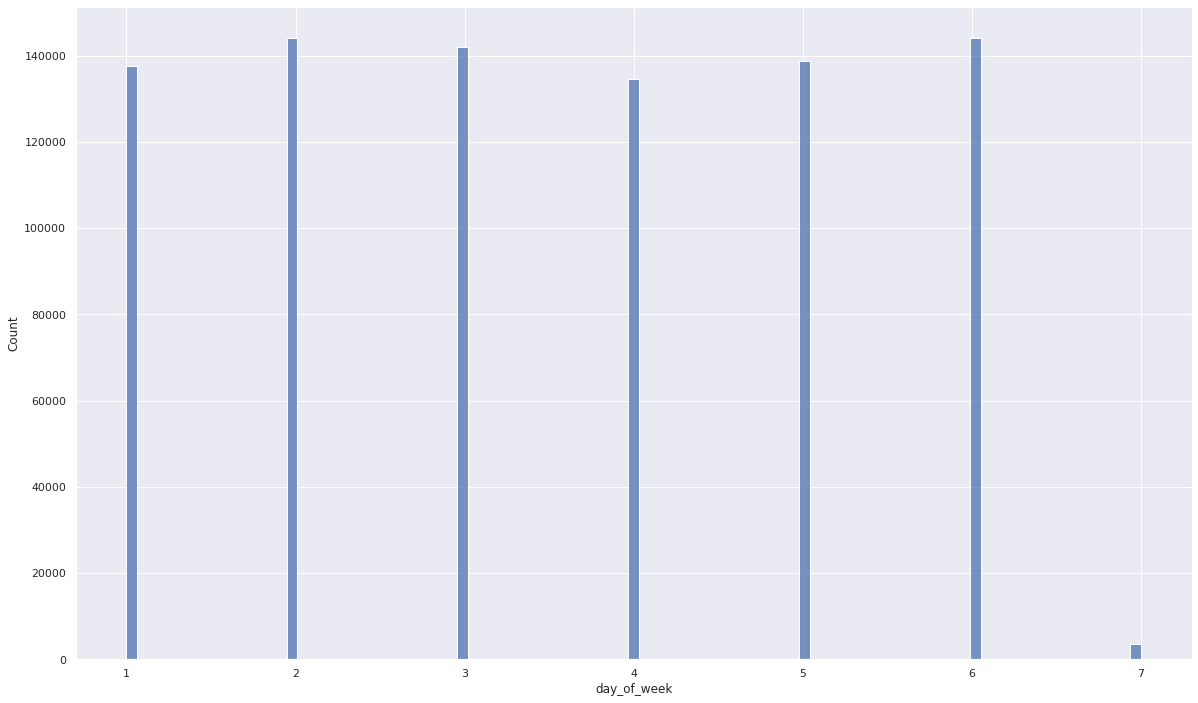

In [67]:
sns.histplot(data=df4["day_of_week"])

But for the stores that open on Sundays, their sales are quite high in comparison to the other week days

<AxesSubplot:>

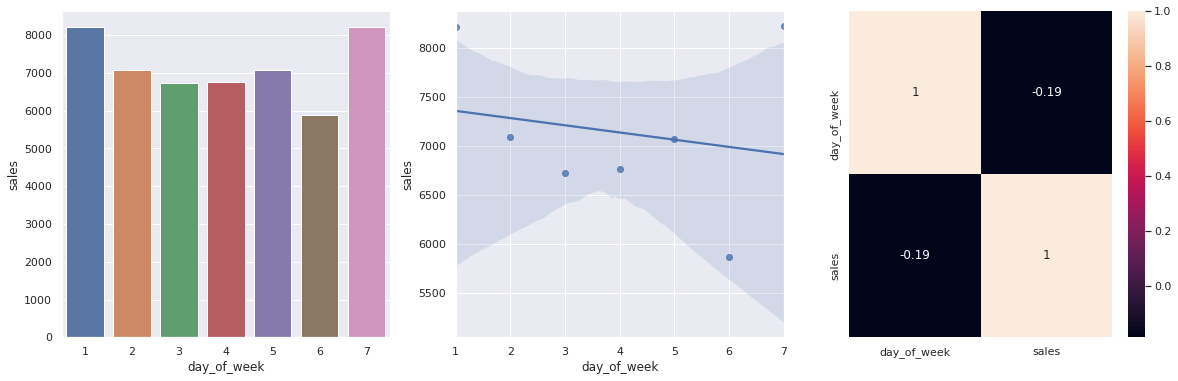

In [68]:
plt.figure(figsize=(20, 6))

plt.subplot(131)
aux1 = df4[["day_of_week", "sales"]].groupby("day_of_week").mean().reset_index()
sns.barplot(data=aux1, x="day_of_week", y="sales")

plt.subplot(132)
sns.regplot(data=aux1, x="day_of_week", y="sales")

plt.subplot(133)
sns.heatmap(aux1.corr(method="pearson"), annot=True)

#### 4.2.1.12. Stores should sell less on school holidays
**FALSE** - Stores genarally sell more on school holidays

<AxesSubplot:xlabel='month', ylabel='sales'>

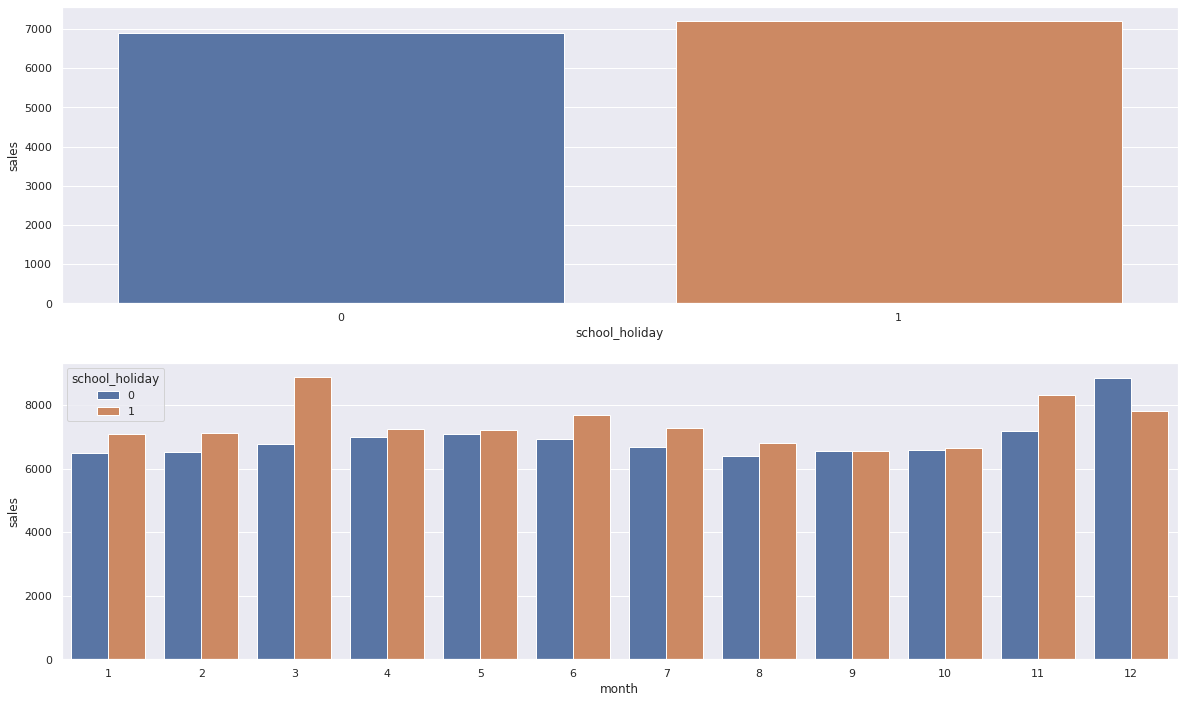

In [69]:
plt.subplot(211)
aux1 = df4[["school_holiday", "sales"]].groupby("school_holiday").mean().reset_index()
sns.barplot(data=aux1, x="school_holiday", y="sales")

plt.subplot(212)
aux1 = df4[["month", "school_holiday", "sales"]].groupby(["school_holiday", "month"]).mean().reset_index()
sns.barplot(data=aux1, x="month", y="sales", hue="school_holiday")

Another way to visualize

<AxesSubplot:xlabel='month'>

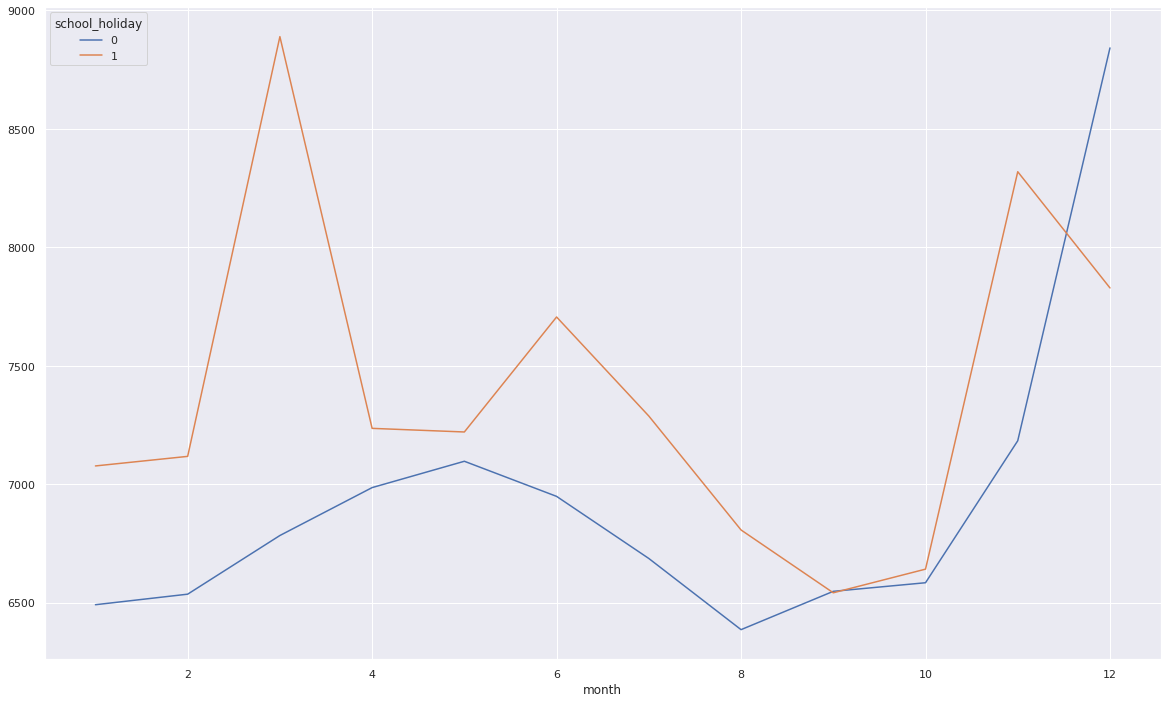

In [70]:
aux1 = df4[["school_holiday", "month", "sales"]]
aux1 = aux1.groupby(["month", "school_holiday"]).mean().reset_index()
aux1 = aux1.pivot(index="month", columns="school_holiday", values="sales")
aux1.plot()



### 4.2.2. Analisys predicated on the added sales values, for the whole business

#### 4.2.1.1 Hypothsis: Stores with larger assorment should sell more

**FALSE** - Individualy, stores with higher assortment sell more (it would be **true**), but in the added value of all stores of each type the higher assortment sold way less 

In an individual analysis level, a single extra type store sells more than either extended or basic type stores

However, since there are way more stores of the the basic and extended assortment type, as was discovered in the univariate analysis, the cumulative profit of this two far exceeds the profit of all the stores of the extra assortment type, as shown bellow

<AxesSubplot:xlabel='assortment', ylabel='sales'>

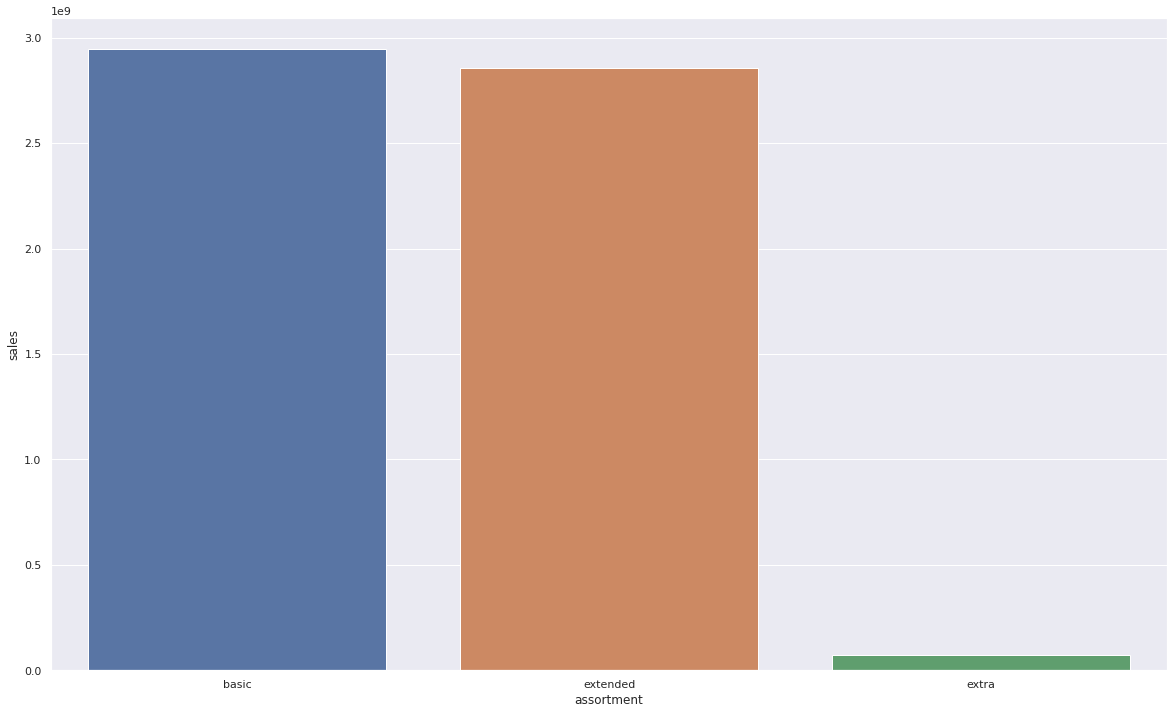

In [71]:
aux2 = df4[["assortment", "sales"]].groupby("assortment").sum().reset_index()
sns.barplot(data=aux2, x="assortment", y="sales")

If the profit of the all extra assortment types is so small in comparison with the other types, one question might be raised: were the profits of the "extras" higher in the begining of the recording day and plumed with time? In other words, was there any interesting variation in the profit along the registered time?

In [72]:
aux3 = df4[["year_week", "assortment", "sales"]].groupby(["year_week", "assortment"]).sum().reset_index()
aux3.head()

,year_week,assortment,sales
0,2013-00,basic,13434262
1,2013-00,extended,12425669
2,2013-00,extra,269404
3,2013-01,basic,26007250
4,2013-01,extended,22917693


In [73]:
# reorganizing the graph
pivot_aux3 = aux3.pivot(index="year_week", columns="assortment", values="sales")
pivot_aux3.head()

assortment,basic,extended,extra
year_week,,,
2013-00,13434262,12425669,269404
2013-01,26007250,22917693,350279
2013-02,17970974,16029584,377207
2013-03,24392076,21243431,404662
2013-04,19972891,18130077,363061


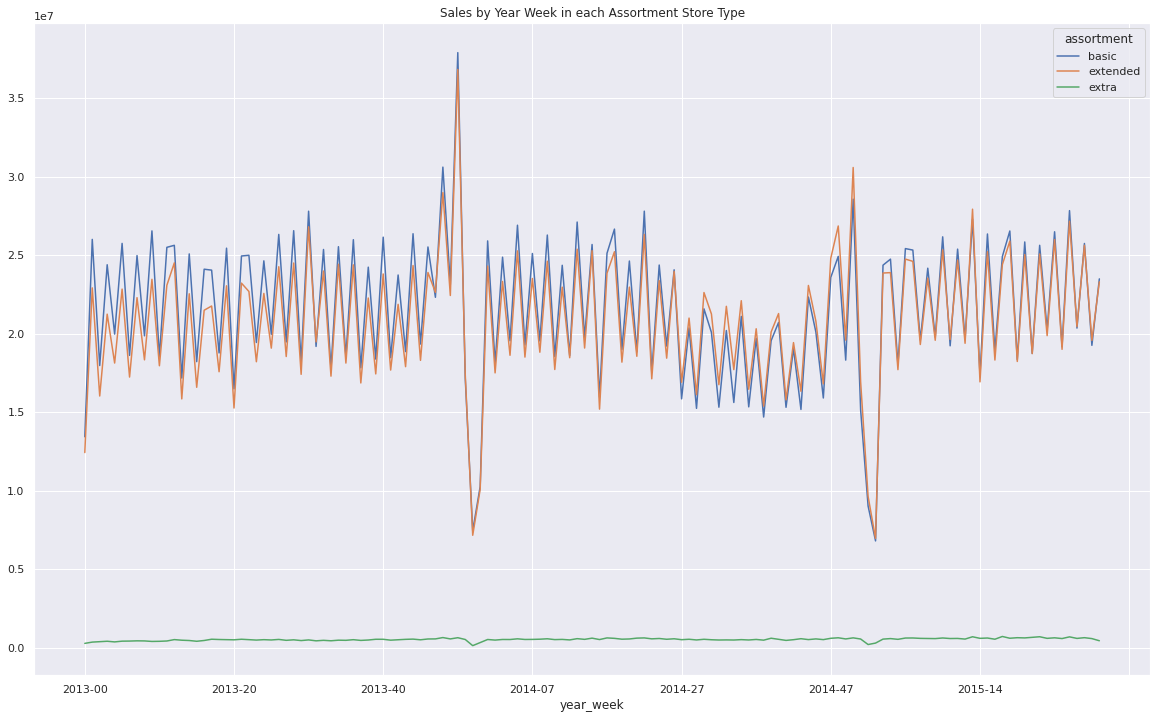

In [74]:
pivot_aux3.plot(title="Sales by Year Week in each Assortment Store Type");

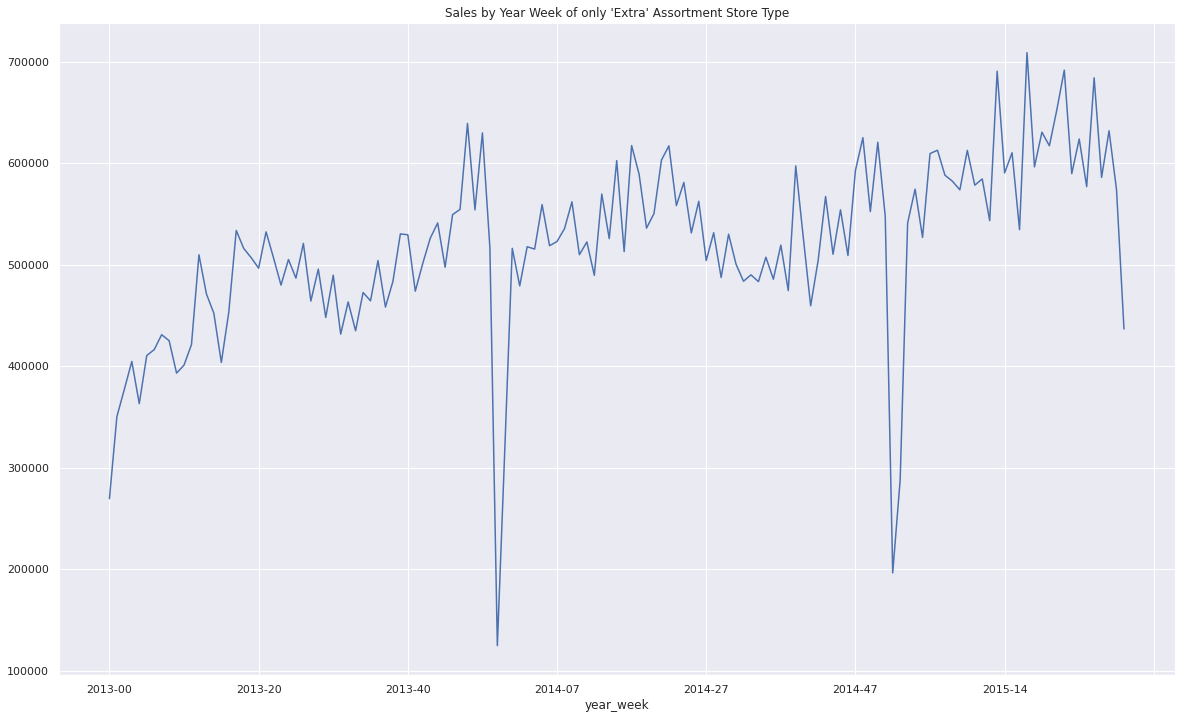

In [75]:
# only of the assortment extra type, zooming in
pivot_aux3["extra"].plot(title="Sales by Year Week of only 'Extra' Assortment Store Type");

#### 4.2.1.2 Hypothesis: Stores with close competitors should sell less
**FALSE** - Since there are way more stores with close competitors, the added sales of those are much higher

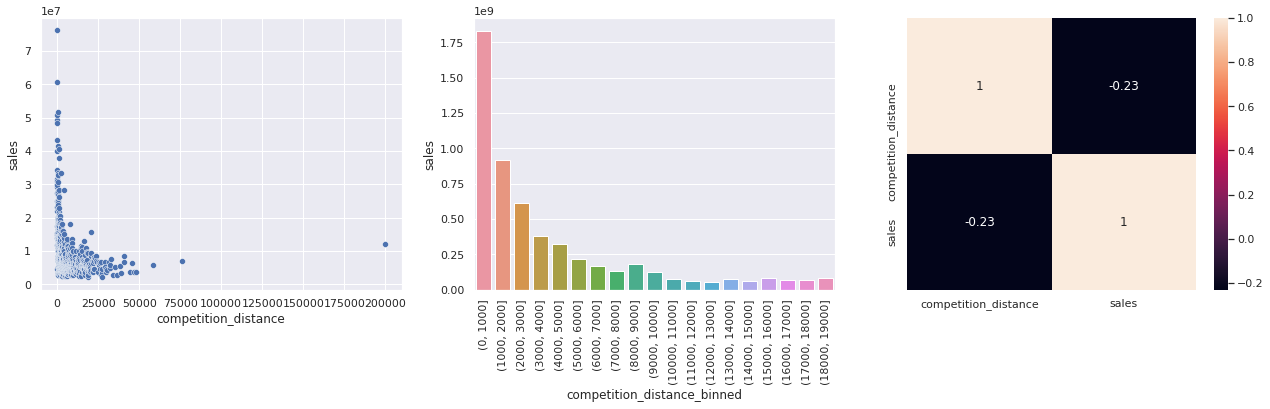

In [76]:
# grouping by exact competition distance made the number of rows 1289 times lower
aux1 = df4[["competition_distance", "sales"]].groupby("competition_distance").sum().reset_index()

plt.figure(figsize=(22, 5))

# ==== SCATTERPLOT =====
plt.subplot(131)
sns.scatterplot(data=aux1, x="competition_distance", y="sales");

# ==== BARPLOT ====
plt.subplot(132)
# however the barplot made with this dataframe is still very dificult to visualize, too many entries (655 to be exact)
# so I will group the distances by distances of 1000, group the distances by bins
# creating bins only until 20000 not 200000, possibly because the higher values are just too small and
# do not influence in the confirmation or not of the hypothesis, the trend as is with 20000 is clear enough
bins = list( range( 0, 20000, 1000 ) )

# pd.cut is made exactaly for assigning values to bins, numerical values to categorical
aux1["competition_distance_binned"] = pd.cut( x=aux1["competition_distance"], bins=bins )
aux2 = aux1[["competition_distance_binned", "sales"]].groupby("competition_distance_binned").sum().reset_index()
sns.barplot(data=aux2, x="competition_distance_binned", y="sales");
plt.xticks( rotation=90 )

# ==== CORRELATION HEATMAP ====
# the value can go from 1 to -1, where 0 means no correlation
# -0.23 means that there is a small negative correlation, meaning that the greater the distance smaller the sales
plt.subplot(133)
sns.heatmap(aux1.corr(method="pearson"), annot=True);

By the previous analysis the stores that have nearer competitors have a higher sale.

Howerver, this phenomenon only occurs because there are much more stores with close competitors in the data:

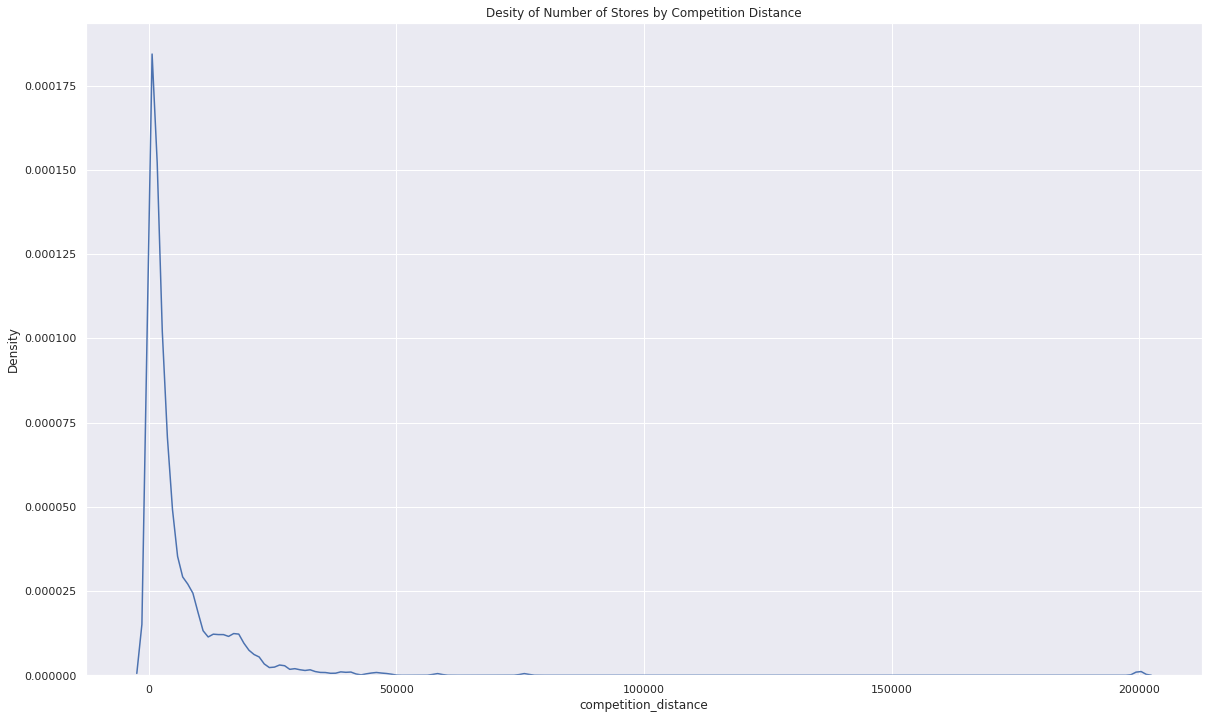

In [77]:
plt.title("Desity of Number of Stores by Competition Distance")
sns.kdeplot(data=df4["competition_distance"]);

#### 4.2.1.3. Stores with longer-term competitors should sell more
**FALSE** - There are much less recordings for stores with long term competitors, so the sales seems to decrease

By the analysis bellow the relation between long-term competitors and sales is negative, the longer the competition, smaller the sales

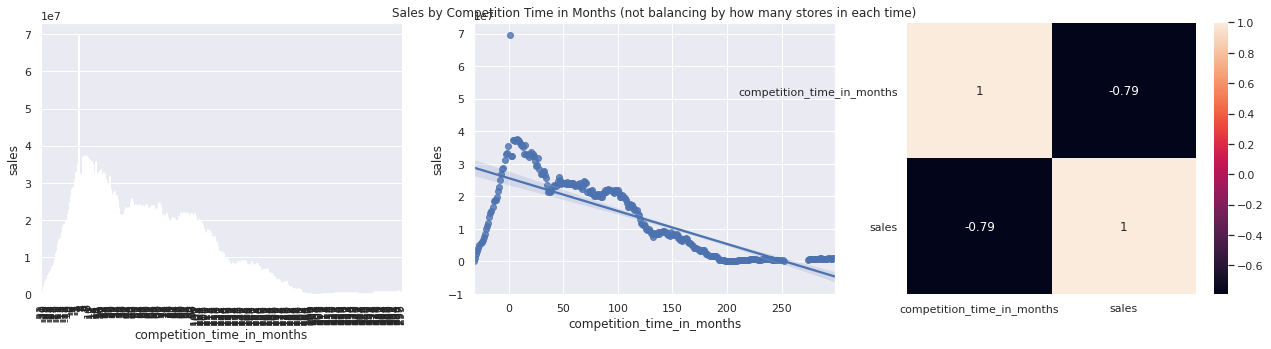

In [78]:
aux1 = df4[["competition_time_in_months", "sales"]].groupby("competition_time_in_months").sum().reset_index()
aux1 = aux1[(aux1["competition_time_in_months"] != 0) & (aux1["competition_time_in_months"] < 300)]

plt.figure(figsize=(22, 5))

plt.subplot(131)
sns.barplot(data=aux1, x="competition_time_in_months", y="sales")
plt.xticks(rotation=90);

plt.subplot(132)
sns.regplot(data=aux1, x="competition_time_in_months", y="sales");
plt.title("Sales by Competition Time in Months (not balancing by how many stores in each time)");

plt.subplot(133)
sns.heatmap(aux1.corr(method="pearson"), annot=True);

Yet, one must take into account that this value have a strong influence comming from the ammount of stores that were measured that were concentrated around the 0. This naturaly make a peak in sales in this months, meaning that since we have more stores around the 0, when we sum up them, we have a higher cumulative sale.

Bellow is shown the higher concentration of measures around 0

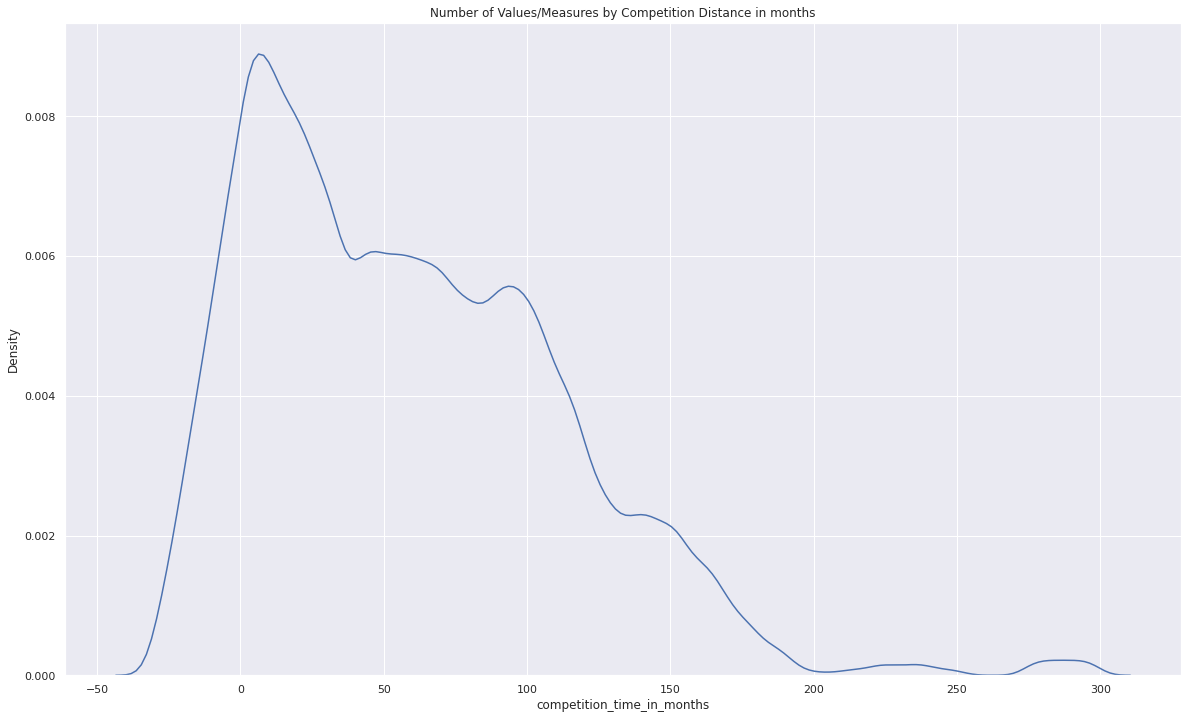

In [79]:
aux1 = df4.loc[(df4["competition_time_in_months"] != 0) & (df4["competition_time_in_months"] < 300), ["competition_time_in_months", "sales"]]
sns.kdeplot(data=aux1, x="competition_time_in_months");
plt.title("Number of Values/Measures by Competition Distance in months");

Bellow is the exact actions made above (except the bar chart that was too difficult to visualize), just that now we are taking the mean of values in any given month, effectively removing the additional effect of the greater amount of data around the 0 months

Therefore discovering a positive high correlation between the variables, meaning that yes, the sales go up the longer the competition time span

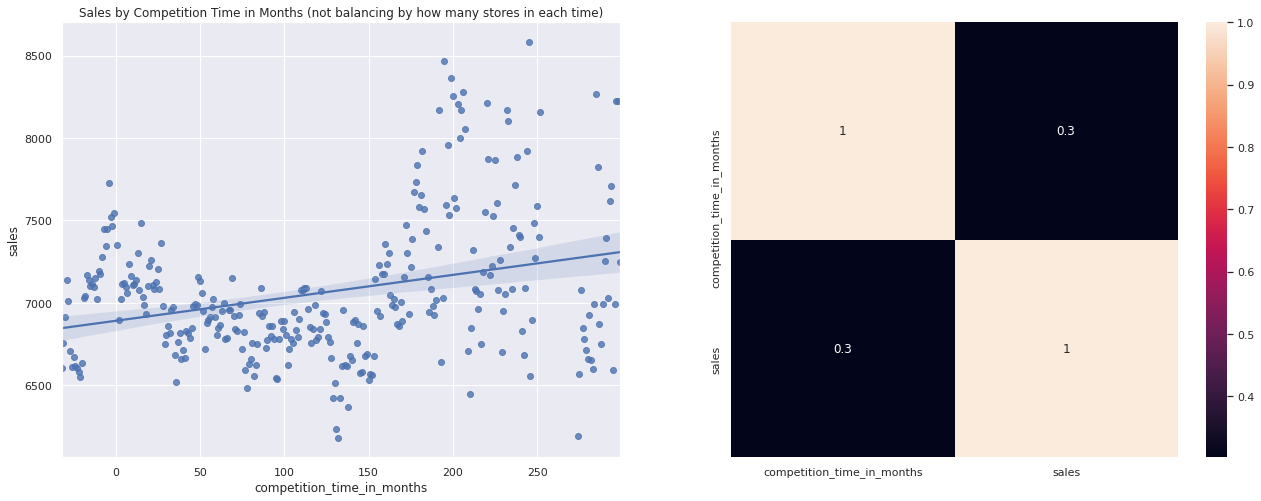

In [80]:
aux1 = df4[["competition_time_in_months", "sales"]].groupby("competition_time_in_months").mean().reset_index()
aux1 = aux1[(aux1["competition_time_in_months"] != 0) & (aux1["competition_time_in_months"] < 300)]

plt.figure(figsize=(22, 8))

plt.subplot(121)
sns.regplot(data=aux1, x="competition_time_in_months", y="sales");
plt.title("Sales by Competition Time in Months (not balancing by how many stores in each time)");

plt.subplot(122)
sns.heatmap(aux1.corr(method="pearson"), annot=True);

#### 4.2.1.4  Stores with longer sales (promotions) periods should sell more - Is sales growing inside Promo2?
**FALSE** - The added value for sales appears to decrease. This is caused for the much lower amount of stores that are longer term "promo2"

**However** We can not say that the growth of sales is directly related to the longer Promo2, that it is the cause. There are many factors influencing the growth of the stores, this might be even a natural growth related to the natural growth of a store after it opens. It is only a correlation! 

<AxesSubplot:>

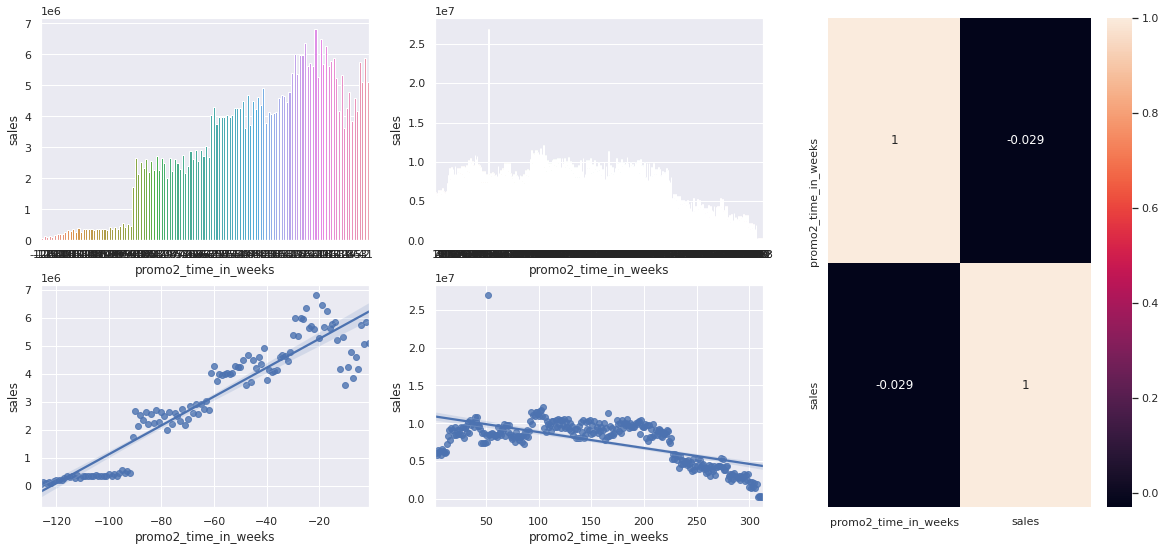

In [81]:
aux1 = df4[["promo2_time_in_weeks", "sales"]].groupby("promo2_time_in_weeks").sum().reset_index()

plt.figure(figsize=(20, 9))
grid = gridspec.GridSpec(2, 3)

plt.subplot(grid[0, 0])
aux2 = aux1[aux1["promo2_time_in_weeks"] < 0]
sns.barplot(data=aux2, x="promo2_time_in_weeks", y="sales");

plt.subplot(grid[0, 1])
aux3 = aux1[aux1["promo2_time_in_weeks"] > 0]
sns.barplot(data=aux3, x="promo2_time_in_weeks", y="sales");

plt.subplot(grid[1, 0])
sns.regplot(data=aux2, x="promo2_time_in_weeks", y="sales");

plt.subplot(grid[1, 1])
sns.regplot(data=aux3, x="promo2_time_in_weeks", y="sales");

# the correlation is made using the whole dataset (aux1 here), not the parts
plt.subplot(grid[:, 2])
sns.heatmap(aux1.corr(method="pearson"), annot=True)

The plots above were analysing the data without considering the higher amount of data registered for stores that were in promo2 between 0 and 200 weeks, as shown in the graph bellow. Because of that, when adding all the values, the result is inflated, more values are added for these days, resulting in more cumulative sales.

<AxesSubplot:ylabel='Count'>

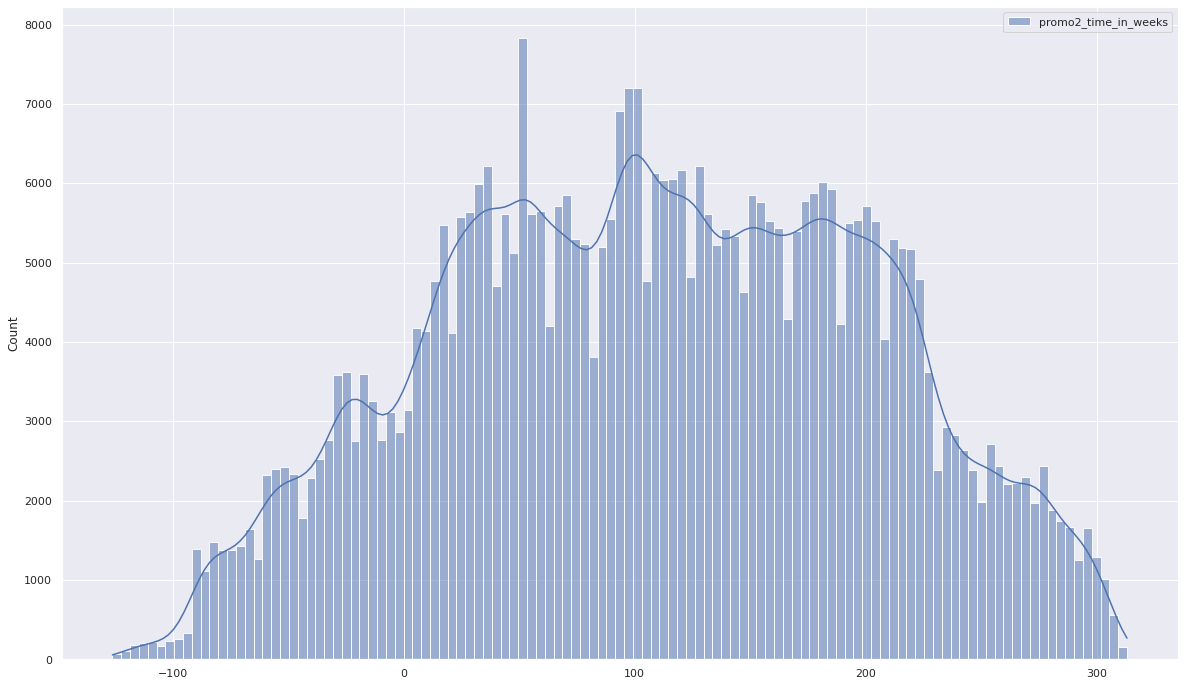

In [82]:
aux1 = df4.loc[df4["promo2_time_in_weeks"] != 0, ["promo2_time_in_weeks"]]
sns.histplot(data=aux1, kde=True)

Taking that into consideration we may take the mean, not the sum, in order to balance the data. This way the higher amount of registered measures of stores between 0 and 200 will make less of a impact in the result

<AxesSubplot:>

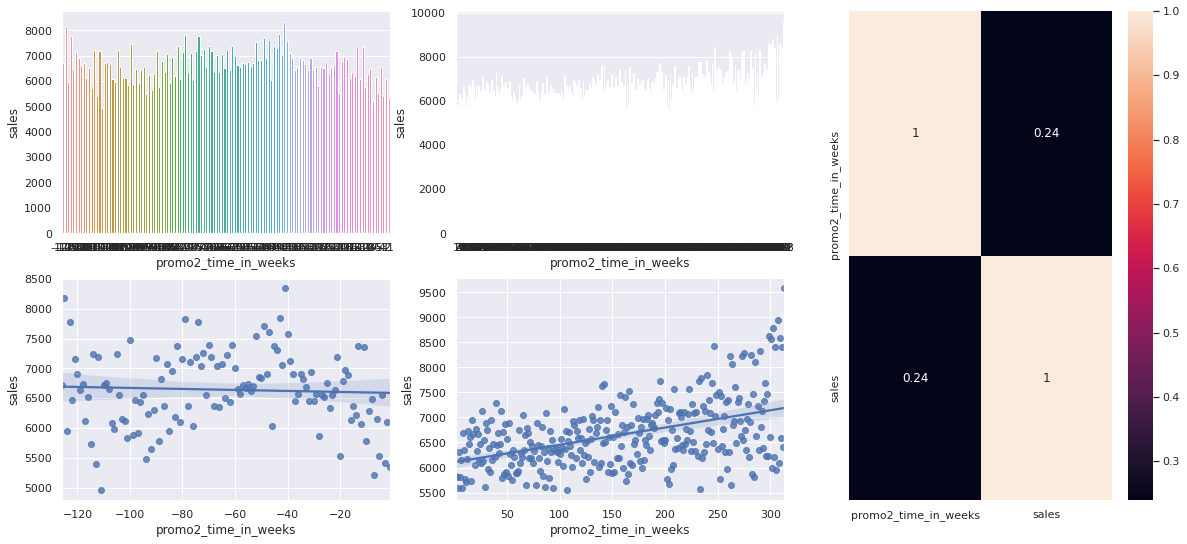

In [83]:
aux1 = df4[["promo2_time_in_weeks", "sales"]].groupby("promo2_time_in_weeks").mean().reset_index()

plt.figure(figsize=(20, 9))
grid = gridspec.GridSpec(2, 3)

plt.subplot(grid[0, 0])
aux2 = aux1[aux1["promo2_time_in_weeks"] < 0]
sns.barplot(data=aux2, x="promo2_time_in_weeks", y="sales");

plt.subplot(grid[0, 1])
aux3 = aux1[aux1["promo2_time_in_weeks"] > 0]
sns.barplot(data=aux3, x="promo2_time_in_weeks", y="sales");

plt.subplot(grid[1, 0])
sns.regplot(data=aux2, x="promo2_time_in_weeks", y="sales");

plt.subplot(grid[1, 1])
sns.regplot(data=aux3, x="promo2_time_in_weeks", y="sales");

# the correlation is made using the whole dataset (aux1 here), not the parts
plt.subplot(grid[:, 2])
sns.heatmap(aux1.corr(method="pearson"), annot=True)

#### <s>4.2.1.5. Stores with longer sales consecutive days should sell more</s>

I do not believe that there is data to test the hypothesis

#### 4.2.1.6 Stores with more consecutive promotions should sell more
**FALSE** - Stores with "promo2" sell less than without, the higher sellers are the ones with only "promo"

In [84]:
df4[["promo", "promo2", "sales"]].groupby(["promo", "promo2"]).sum().reset_index().sort_values(by="sales")

,promo,promo2,sales
1,0,1,1289362241
3,1,1,1472275754
0,0,0,1482612096
2,1,0,1628930532


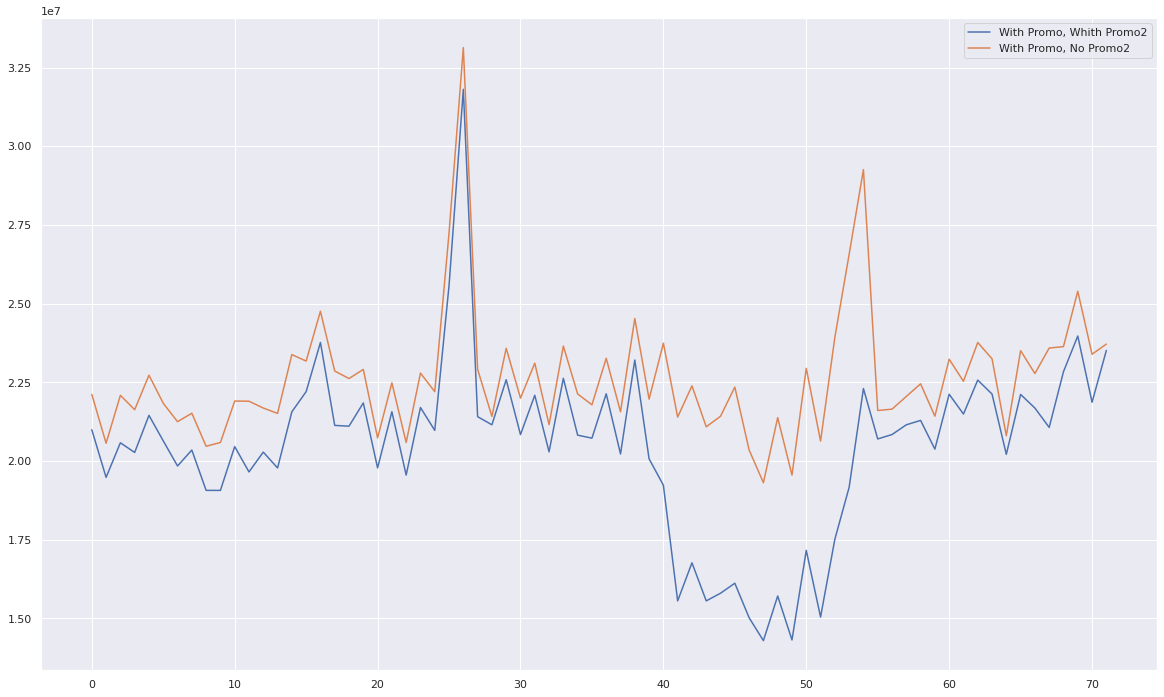

In [85]:
aux1 = df4.loc[(df4["promo"] == 1) & (df4["promo2"] == 1), ["year_week", "sales"]].groupby("year_week").sum().reset_index()
ax = aux1.plot()

aux2 = df4.loc[(df4["promo"] == 1) & (df4["promo2"] == 0), ["year_week", "sales"]].groupby("year_week").sum().reset_index()
aux2.plot(ax=ax)

ax.legend(labels=["With Promo, Whith Promo2", "With Promo, No Promo2"])

#### 4.2.1.7. Stores sells more on Christmas holiday 
**FALSE** - The added value for stores' sales on Christmas is lower. For there are much less stores opening in Christmas.

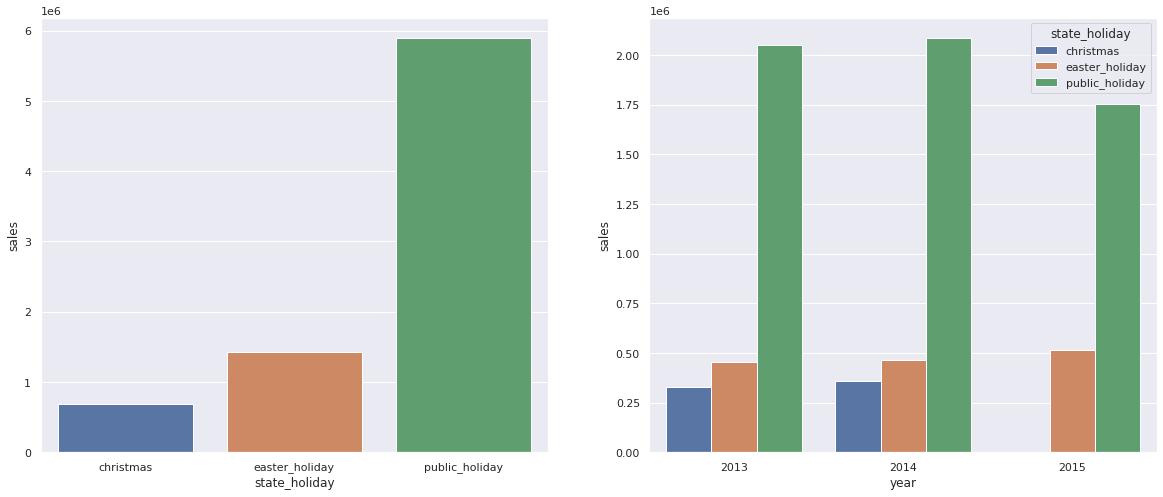

In [86]:
plt.figure(figsize=(20, 8))

plt.subplot(121)
aux = df4[df4["state_holiday"] != "regular_day"]
aux1 = aux[["state_holiday", "sales"]].groupby("state_holiday").sum().reset_index()
sns.barplot(data=aux1, y="sales", x="state_holiday");

plt.subplot(122)
aux2 = aux[["year", "state_holiday", "sales"]].groupby(["year", "state_holiday"]).sum().reset_index()
sns.barplot(data=aux2, y="sales", x="year", hue="state_holiday");

#### 4.2.1.8. Stores should sell more over the years
**FALSE** - The added stores sales seems to be going down over the years. **However** this seems to be generated by the proportional decrease in measures taken over the years, less stores in the database. There can be less stores measured in the data or this can be a real thing, there are less stores opened. In the analysis taking this into account the average store is selling more over the years

<AxesSubplot:title={'center':'Number of Stores Measured per Year'}, xlabel='year', ylabel='count'>

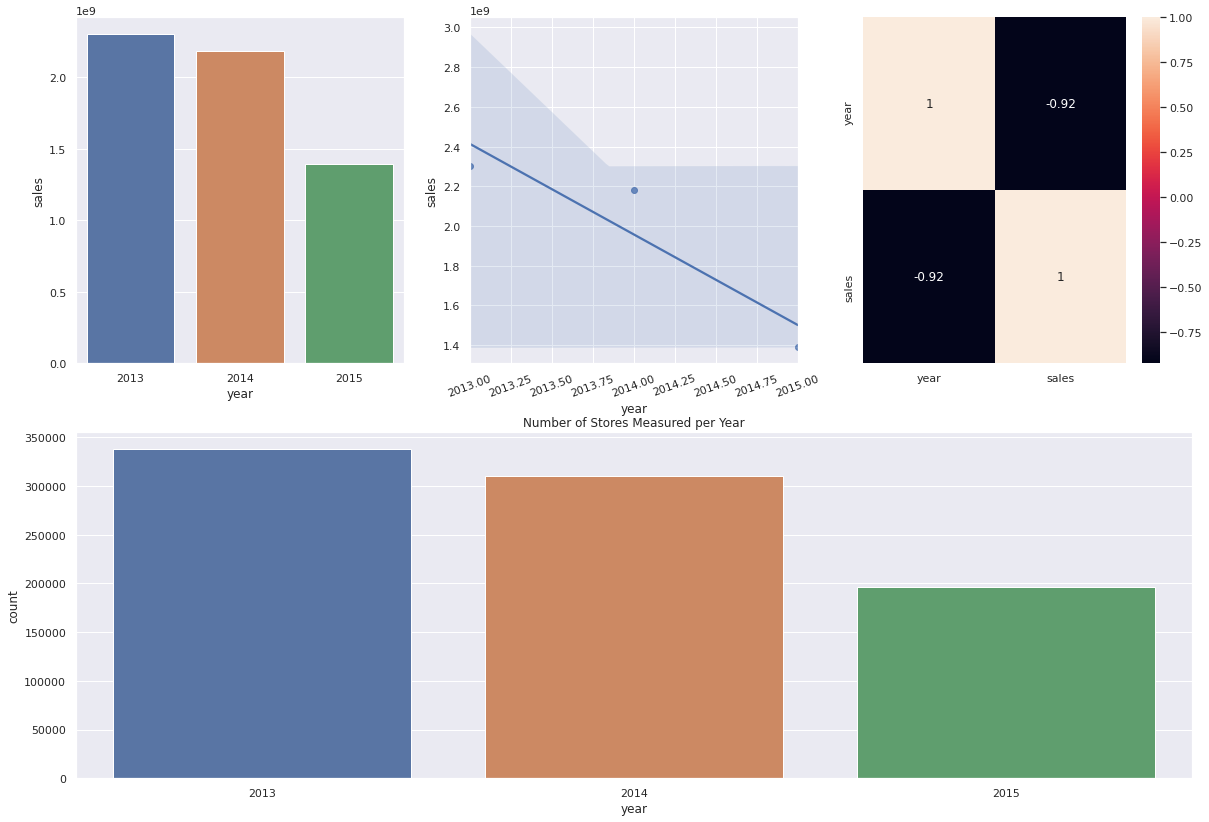

In [87]:
plt.figure(figsize=(20, 14))
grid = gridspec.GridSpec(2, 3)

plt.subplot(grid[0, 0])
aux1 = df4[["year", "sales"]].groupby("year").sum().reset_index()
sns.barplot(data=aux1, x="year", y="sales")

plt.subplot(grid[0, 1])
sns.regplot(data=aux1, x="year", y="sales")
plt.xticks(rotation=20)

plt.subplot(grid[0, 2])
sns.heatmap(aux1.corr(method="pearson"), annot=True)

plt.subplot(grid[1, :]).set_title("Number of Stores Measured per Year")
sns.countplot(data=df4, x="year")

#### 4.2.1.9. Stores should sell more during the last half of the year
**FALSE** - The added value is lower

<AxesSubplot:>

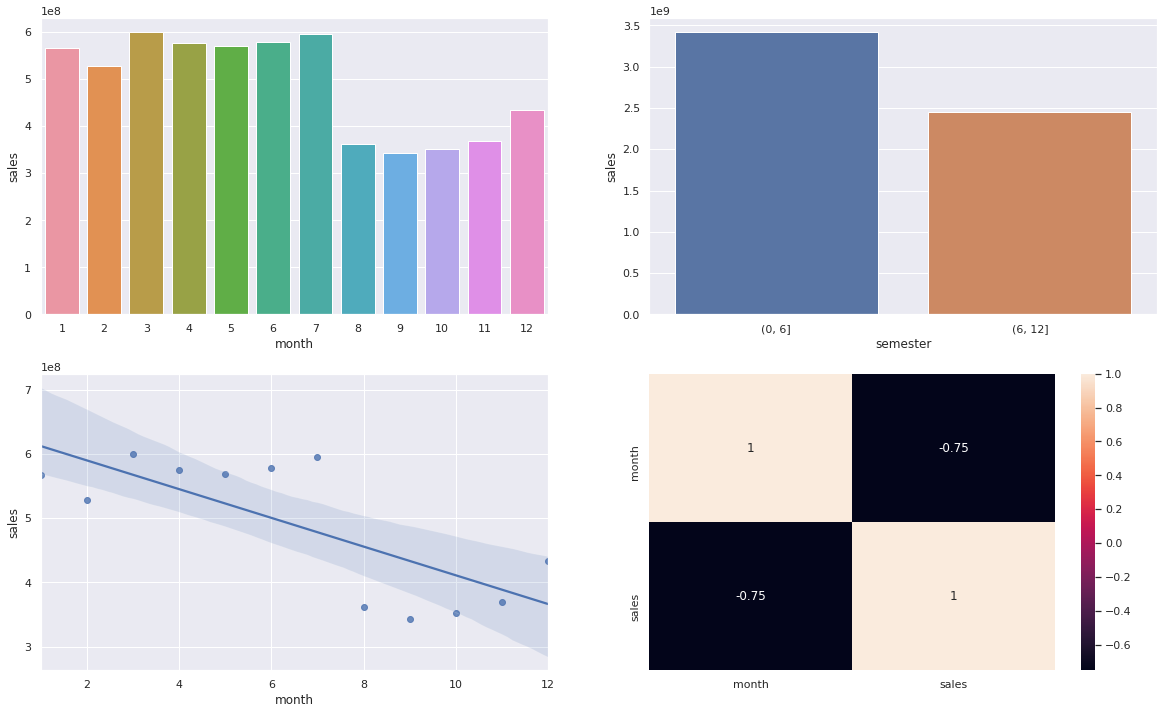

In [88]:
plt.figure(figsize=(20, 12))

plt.subplot(221)
aux1 = df4[["month", "sales"]].groupby("month").sum().reset_index()
sns.barplot(data=aux1, x="month", y="sales")

plt.subplot(222)
aux2 = aux1.copy()
aux2["semester"] = pd.cut(x=aux1["month"], bins=list(range(0, 13, 6)))
aux2 = aux2[["semester", "sales"]].groupby("semester").sum().reset_index()
sns.barplot(data=aux2, x="semester", y="sales");

plt.subplot(223)
sns.regplot(data=aux1, x="month", y="sales")

plt.subplot(224)
sns.heatmap(aux1.corr(method="pearson"), annot=True)

#### 4.2.1.10. Stores should sell more after the tenth day of the month
**TRUE** - Store added sales are higher after the tenth day of the month

<AxesSubplot:xlabel='before_after', ylabel='sales'>

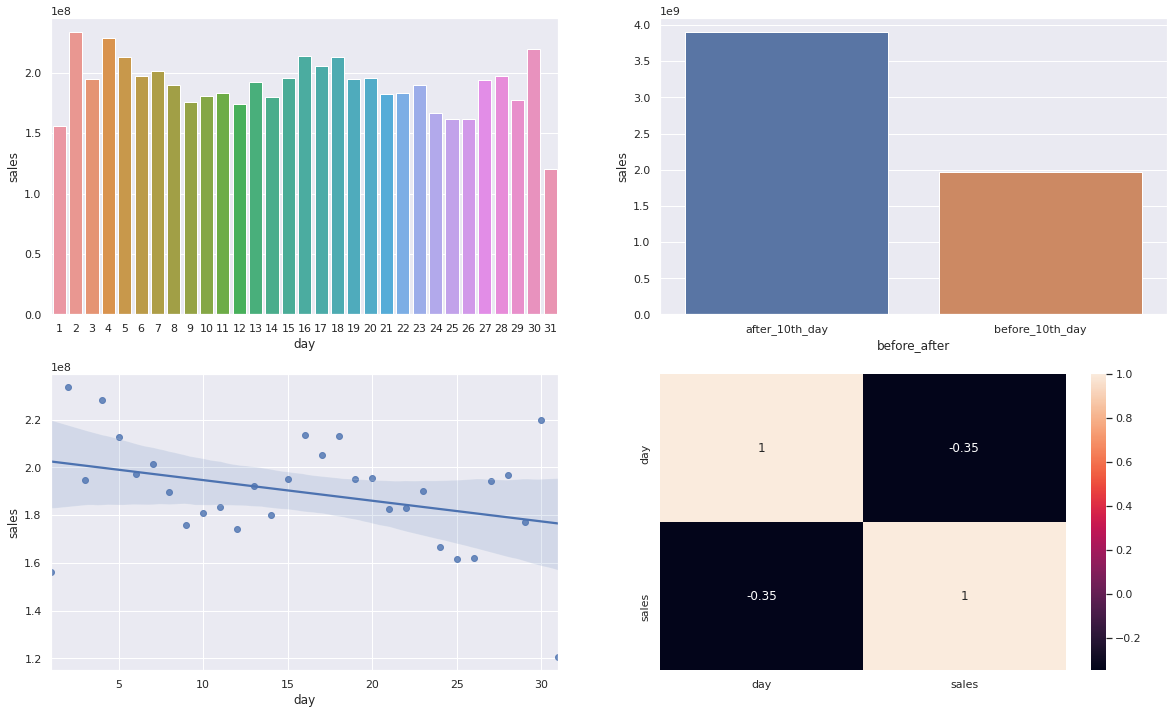

In [89]:
plt.figure(figsize=(20, 12))

plt.subplot(221)
aux1 = df4[["day", "sales"]].groupby("day").sum().reset_index()
sns.barplot(data=aux1, x="day", y="sales")

plt.subplot(223)
sns.regplot(data=aux1, x="day", y="sales")

plt.subplot(224)
sns.heatmap(aux1.corr(method="pearson"), annot=True)

plt.subplot(222)
aux1["before_after"] = aux1["day"].apply(lambda x: "before_10th_day" if x <= 10 else "after_10th_day")
aux2 = aux1.groupby("before_after").sum().reset_index()
sns.barplot(data=aux2, x="before_after", y="sales")

#### 4.2.1.11. Stores should sell less on weekends
**TRUE** - Stores cumulative sales are way lower in weekends. This is caused by the much smaller amount of stores opened on Sundays

<AxesSubplot:>

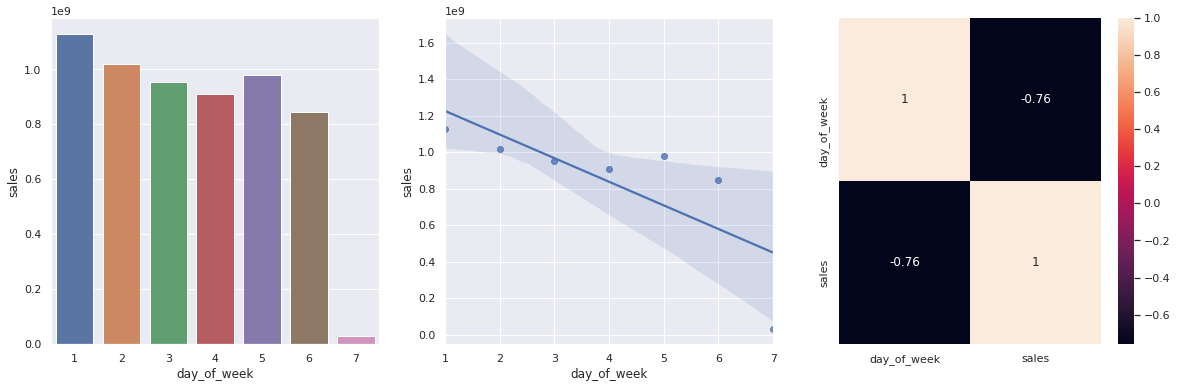

In [90]:
plt.figure(figsize=(20, 6))

plt.subplot(131)
aux1 = df4[["day_of_week", "sales"]].groupby("day_of_week").sum().reset_index()
sns.barplot(data=aux1, x="day_of_week", y="sales")

plt.subplot(132)
sns.regplot(data=aux1, x="day_of_week", y="sales")

plt.subplot(133)
sns.heatmap(aux1.corr(method="pearson"), annot=True)

Sales on sunday are very low. This is caused by the greater number of stores closed on Sundays:

<AxesSubplot:xlabel='day_of_week', ylabel='Count'>

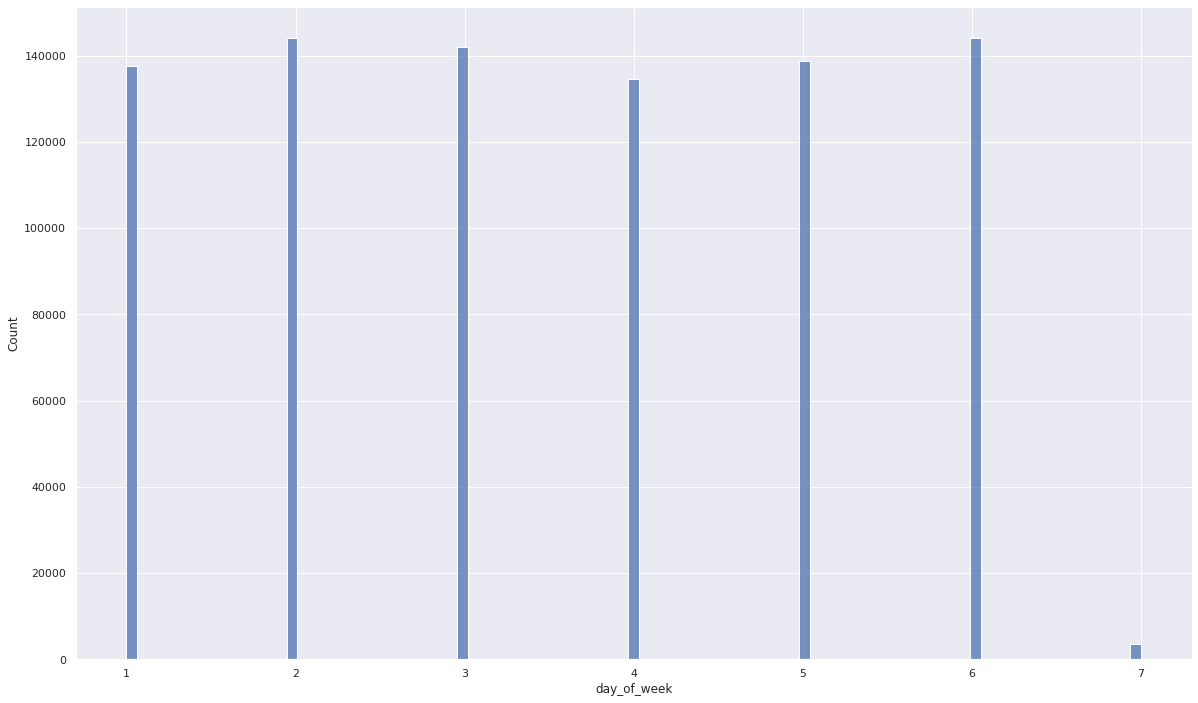

In [91]:
sns.histplot(data=df4["day_of_week"])

But for the stores that open on Sundays, their sales are quite high in comparison to the other week days

<AxesSubplot:>

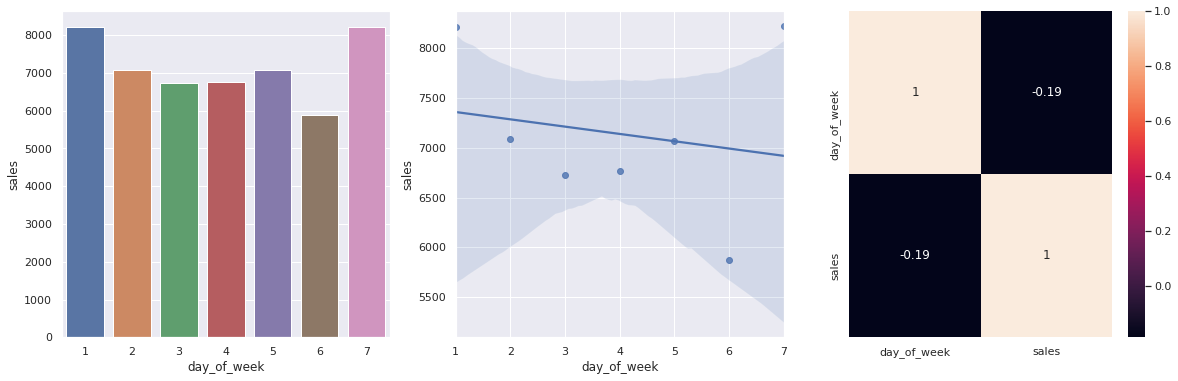

In [92]:
plt.figure(figsize=(20, 6))

plt.subplot(131)
aux1 = df4[["day_of_week", "sales"]].groupby("day_of_week").mean().reset_index()
sns.barplot(data=aux1, x="day_of_week", y="sales")

plt.subplot(132)
sns.regplot(data=aux1, x="day_of_week", y="sales")

plt.subplot(133)
sns.heatmap(aux1.corr(method="pearson"), annot=True)

#### 4.2.1.12. Stores should sell less on school holidays
**TRUE** - The added sales value for school holidays is much lower. For there are much less school holidays than days without school holidays. On august, schools are mostly closed, the sales are inverted 

<AxesSubplot:xlabel='month', ylabel='sales'>

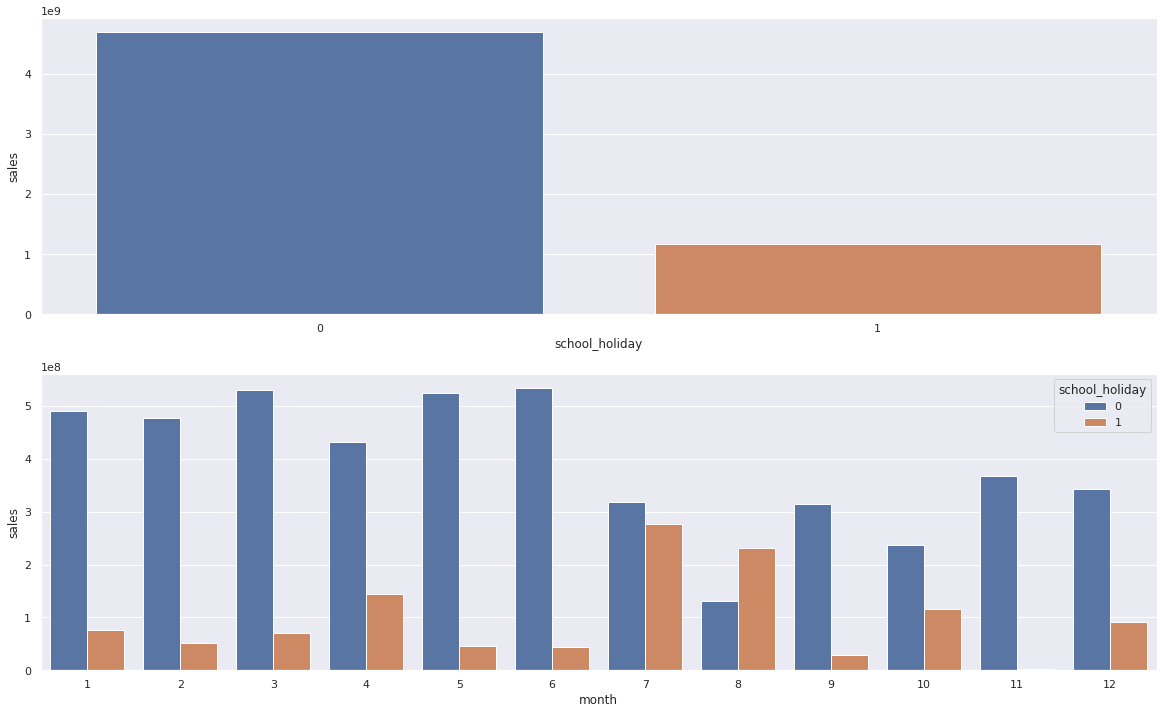

In [93]:
plt.subplot(211)
aux1 = df4[["school_holiday", "sales"]].groupby("school_holiday").sum().reset_index()
sns.barplot(data=aux1, x="school_holiday", y="sales")

plt.subplot(212)
aux1 = df4[["month", "school_holiday", "sales"]].groupby(["school_holiday", "month"]).sum().reset_index()
sns.barplot(data=aux1, x="month", y="sales", hue="school_holiday")

<AxesSubplot:xlabel='month'>

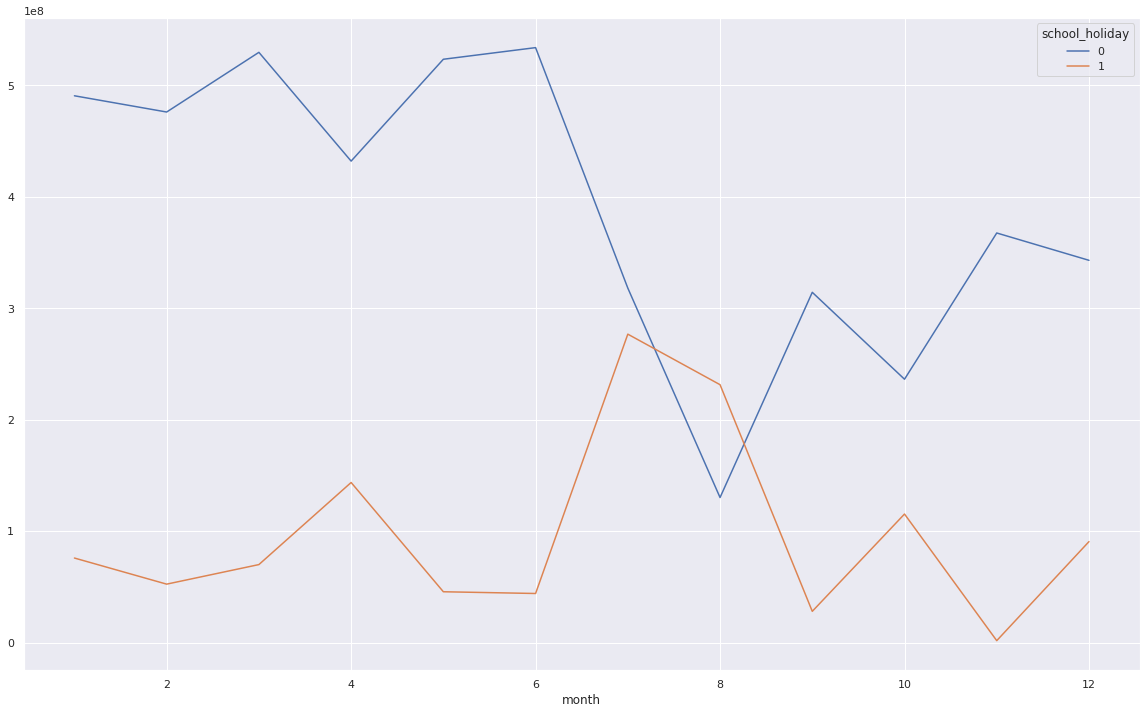

In [94]:
aux1 = df4[["school_holiday", "month", "sales"]]
aux1 = aux1.groupby(["month", "school_holiday"]).sum().reset_index()
aux1 = aux1.pivot(index="month", columns="school_holiday", values="sales")
aux1.plot()



Much more regular days than school holidays

<AxesSubplot:xlabel='month', ylabel='count'>

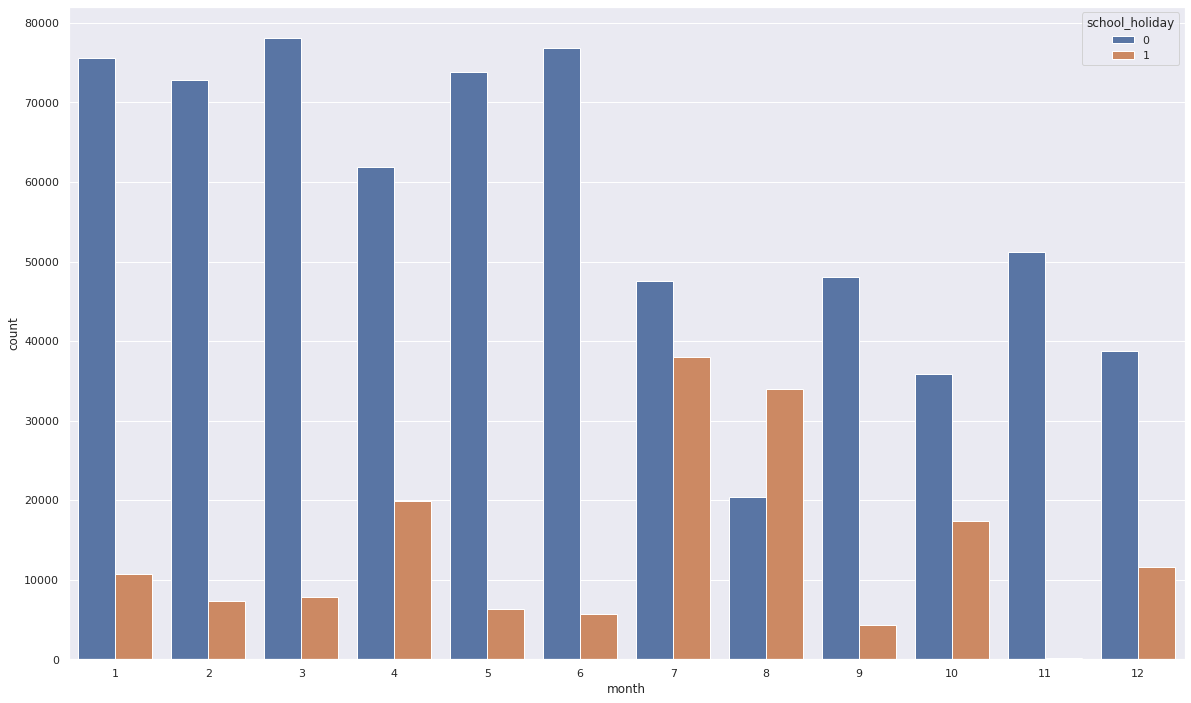

In [95]:
sns.countplot(data=df4[["school_holiday", "month", "sales"]], x="month", hue="school_holiday")

## 4.3. Multivariate Analysis

### 4.3.1. Numerical attributes

<AxesSubplot:>

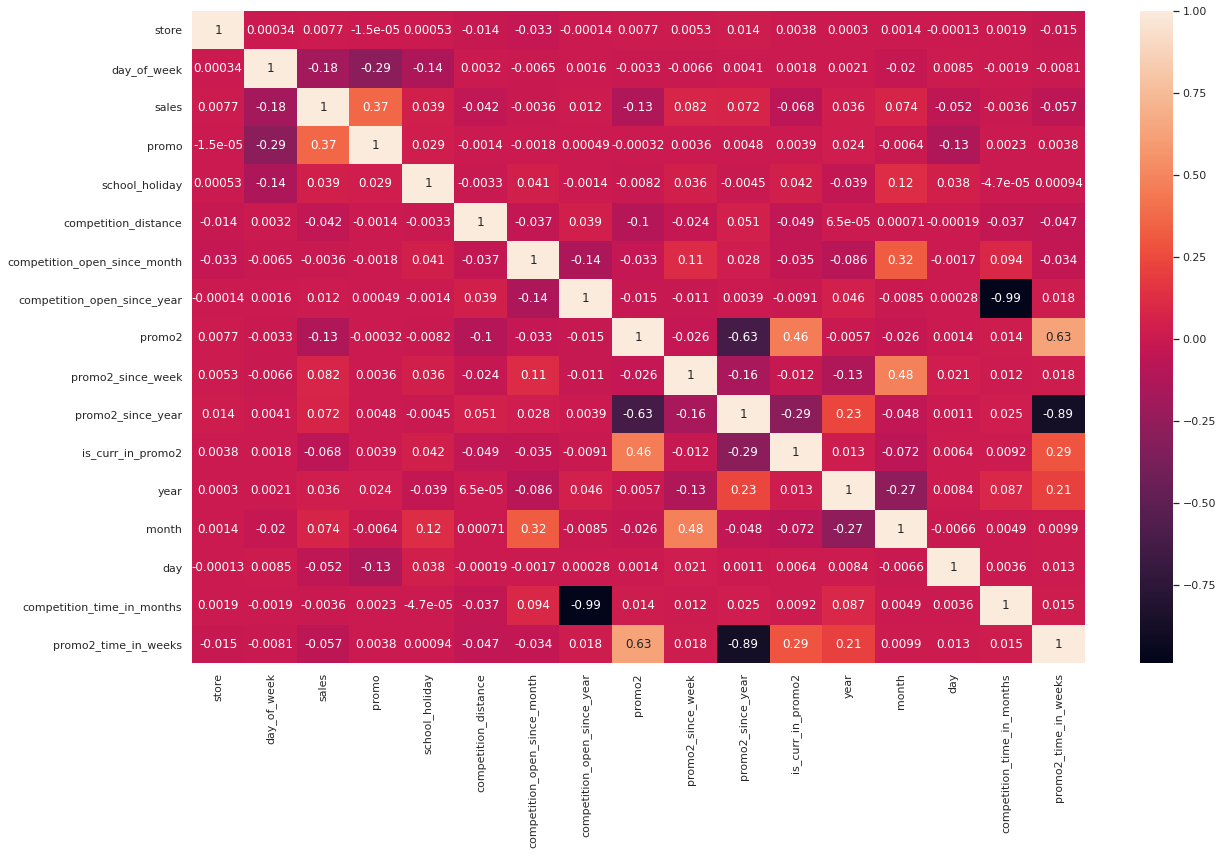

In [96]:
num_correlation = num_attributes.corr(method="pearson")
sns.heatmap(data=num_correlation, annot=True)

### 4.3.2. Nominal attributes

To calculate correlation between nominal variables the method to be used here is the Cramer's V. It is a variation of a chi squared test

<AxesSubplot:>

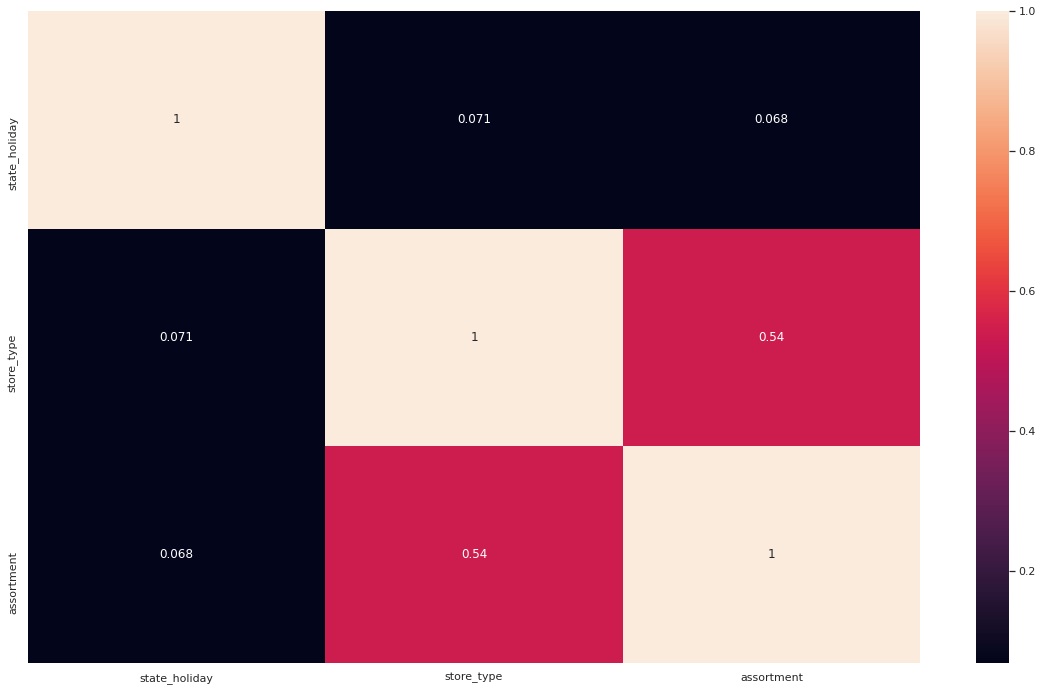

In [97]:
# the cramer_v is not a method from a library,
# it is function is a custom function writen by me in the helper functions section,
# based on the cramer_v formula

a = cramer_v( df4["state_holiday"], df4["state_holiday"] )
b = cramer_v( df4["state_holiday"], df4["store_type"] )
c = cramer_v( df4["state_holiday"], df4["assortment"] )

a1 = cramer_v( df4["store_type"], df4["state_holiday"] )
b1 = cramer_v( df4["store_type"], df4["store_type"] )
c1 = cramer_v( df4["store_type"], df4["assortment"] )

a2 = cramer_v( df4["assortment"], df4["state_holiday"] )
b2 = cramer_v( df4["assortment"], df4["store_type"] )
c2 = cramer_v( df4["assortment"], df4["assortment"] )

d = pd.DataFrame( {
    "state_holiday": [a, b, c],
    "store_type": [a1, b1, c1],
    "assortment": [a2, b2, c2]
    } )
d = d.set_index( d.columns )

sns.heatmap(data=d, annot=True)

# 5.0. Data preparation

There are 3 types of data transformation that we can do.

One of the two main reasons we want to prepare the data for the ML process is that we want to transform the categorical data to numerical and we want to make all data in the same scale

In [98]:
df5 = df4.copy()

## 5.1. Normalization

Normalize data that is already in a normal distribution

According to section 4.1.2 Numerical variable of the exploratory analysis we can see that no values are in normal distributions, so we do not perform normalizations

## 5.2. Rescaling

For non-cyclic numerical values, using **Min-Max Scaler** or **Robust Scaler**

The min max scaler technique return values in relation to the min max values, the problem is that it is very sensible to outliers, meaning that a very huge value that is not recurrent can make all the common values as small. When the data is rich in outliers better use the robust scaler, that uses the 25 percentile and the 75 as values to relate the data, not sensitive to outliers

In [99]:
# competition distance
# year
# competition_time_in_months
# promo2_time_in_weeks

# use boxplot to take a look at the presence of outliers
num = df5.select_dtypes(include=["int64", "float64"])
num.head()

,store,day_of_week,sales,promo,school_holiday,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_curr_in_promo2,year,month,day,competition_time_in_months,promo2_time_in_weeks
0,1,5,5263,1,1,1270.0,9,2008,0,31,2015,0,2015,7,31,84,0
1,2,5,6064,1,1,570.0,11,2007,1,13,2010,1,2015,7,31,94,279
2,3,5,8314,1,1,14130.0,12,2006,1,14,2011,1,2015,7,31,105,226
3,4,5,13995,1,1,620.0,9,2009,0,31,2015,0,2015,7,31,71,0
4,5,5,4822,1,1,29910.0,4,2015,0,31,2015,0,2015,7,31,4,0


<AxesSubplot:xlabel='competition_distance'>

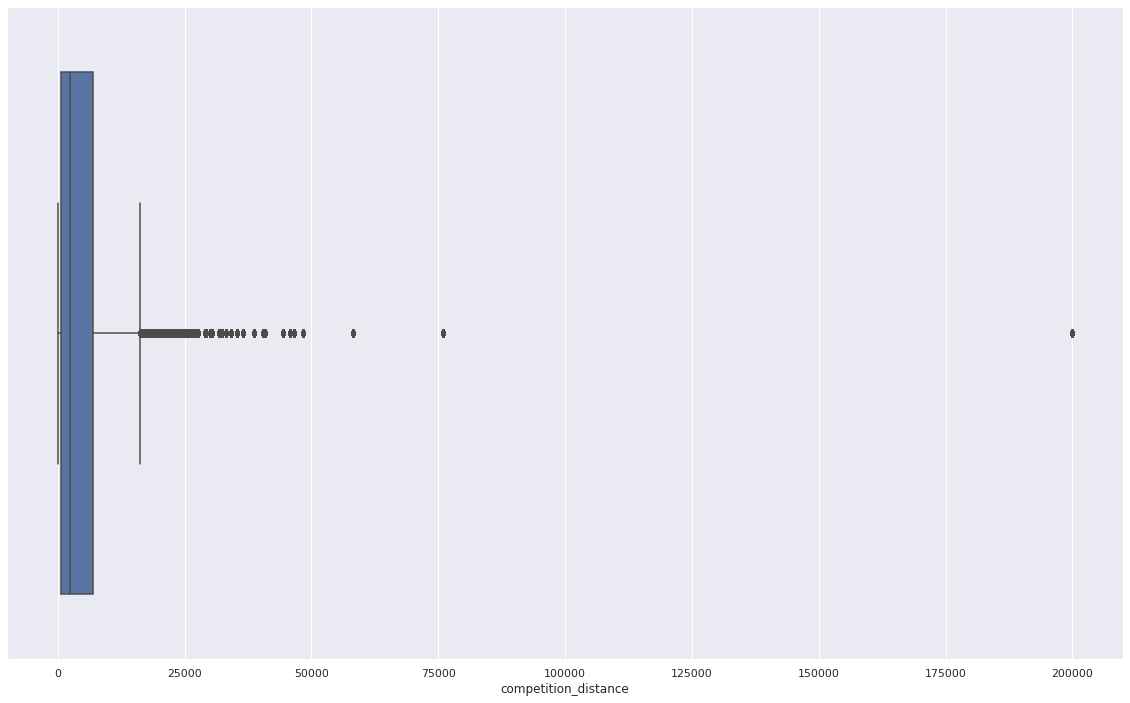

In [100]:
sns.boxplot(x=num["competition_distance"])


## 5.3. Transformation

Cyclic numerical values

# SPACE